In [532]:
import pandas as pd
import numpy as np

In [533]:
### DEFINE BETA VALUES FOR VDF

beta_vals = {} # TBD: compute values based on growth

beta_template_aux = {
    "Period": ["AM", "MD", "PM", "NT"],
    1: [3.246, 3.249, 3.399, 3.402],
    2: [0.715, 0.708, 0.592, 0.708],
    3: [3.130, 3.133, 3.283, 3.286]
}

beta_vals_aux = pd.DataFrame(beta_template_aux)

beta_vals_aux.set_index("Period", inplace=True)

beta_vals[2032] = beta_vals_aux

beta_template_aux = {
    "Period": ["AM", "MD", "PM", "NT"],
    1: [3.350, 3.353, 3.502, 3.506],
    2: [0.715, 0.708, 0.592, 0.708],
    3: [3.130, 3.133, 3.283, 3.286]
}

beta_vals_aux = pd.DataFrame(beta_template_aux)

beta_vals_aux.set_index("Period", inplace=True)

beta_vals[2040] = beta_vals_aux

beta_template_aux = {
    "Period": ["AM", "MD", "PM", "NT"],
    1: [3.479, 3.482, 3.632, 3.635],
    2: [0.715, 0.708, 0.592, 0.708],
    3: [3.130, 3.133, 3.283, 3.286]
}

beta_vals_aux = pd.DataFrame(beta_template_aux)

beta_vals_aux.set_index("Period", inplace=True)

beta_vals[2050] = beta_vals_aux

In [534]:
### DEFINE LOOKUP TABLE FOR BONUS PER PERIOD

lookup_period_file = r"inputs/LookUp_Period.csv"

lookup_period = pd.read_csv(
    lookup_period_file,
    sep=",",          # `delimiter` y `sep` son equivalentes; elige uno
    encoding="utf-8",
    decimal=".",      # parsea decimales con punto
    thousands=",",    # parsea separador de miles con coma
    quotechar='"',
    index_col=0
)

# Clip y reasignar
lookup_period = lookup_period*0

In [535]:
### DEFINE SEGMENT PARAMETERS
# Default configuration for time periods in traffic data

# TBD: Correctly assess the hard_cap, how does the soft cap work?
year_soft_cap = [3.6 / 2, 4.2 / 2, 5.15 / 2]

#year_soft_cap = [3.9 / 2, 3.9 / 2, 3.9 / 2]

#TBD: Make this automatically
period_template = [                 # (Period, Hours/Day, Peak/OP, 4Periods tag)
    ("Night",        6, "OP",   "NT"),
    ("AM-Early",     1, "OP",   "AM"),
    ("AM-Peak",      1, "Peak", "AM"),
    ("AM-Shoulder",  3, "OP",   "AM"),
    ("MD",           4, "OP",   "MD"),
    ("PM-Shoulder",  2, "OP",   "PM"),
    ("PM-Peak",      2, "Peak", "PM"),
    ("PM-Late",      5, "OP",   "PM"),
]

rows = []
years = [2032, 2040, 2050]

# Default time periods list (for reference)
default_time_periods = [
    "Night",
    "AM-Early",
    "AM-Peak",
    "AM-Shoulder",
    "MD",
    "PM-Shoulder",
    "PM-Peak",
    "PM-Late"
]

# Create the base scenario: hour -> time period mapping
hour_to_period = {
    0: "Night",
    1: "Night",
    2: "Night",
    3: "Night",
    4: "Night",
    5: "AM-Early",
    6: "AM-Peak",
    7: "AM-Shoulder",
    8: "AM-Shoulder",
    9: "AM-Shoulder",
    10: "MD",
    11: "MD",
    12: "MD",
    13: "MD",
    14: "PM-Shoulder",
    15: "PM-Shoulder",
    16: "PM-Peak",
    17: "PM-Peak",
    18: "PM-Late",
    19: "PM-Late",
    20: "PM-Late",
    21: "PM-Late",
    22: "PM-Late",
    23: "Night"
}

# Define the segments and their parameters

awt_adt = 1.1 # Average weekday traffic (AWT) to average daily traffic (ADT) ratio
peak_factor = 1.05 # Peak factor for adjustment at peak hour traffic

hov_percentage = pd.DataFrame({
    'Year' : [2032,2040,2050],
    'HOV percentage' : [0,0,0]
})

hov_percentage.set_index('Year', inplace=True)

# Define segment parameters base
seg_params = pd.DataFrame({
    'SegDir':   ["1NB","1SB","2NB","2SB","3NB","3SB","4NB","4SB","5NB","5SB","6NB","6SB","7NB","7SB","8NB","8SB","9NB","9SB","10NB","10SB"],
    'Length':    [0.7,0.7,0.7,0.7,0.5,0.5,1.6,1.6,2,2,3.6,3.6,2.9,2.9,3.8,3.8,3.4,3.4,4.5,4.5],
    'Inscope':   [0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8, 0.8],
    'Lanes_GP':  [4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4], #
    'Lanes_ML':  [2]*20, # Lanes_ML': [2,2,2,2,2,2,2,2,3,3,2,2,2,2], # Do test changing segment 5
    'CapPerLane_GP': [2000]*20,
    'CapPerLane_ML': [1800]*20,
    'Speed_GP':  [55]*6 + [65]*2 + [70]*12,
    'Speed_ML':  [70]*20,
    'Alpha_GP':  [1]*20,
    'Beta_GP':   [6]*20,
    'Alpha_ML':  [1]*20,
    'Beta_ML':   [5]*20,
    'Min_Toll_2016': [None]*20,
    'Max_Toll_2016': [None]*20,
    'LanesGP_AM_Peak': [5]*20,
    'LanesGP_PM_Peak': [5]*20,
})

seg_params.set_index('SegDir', inplace=True)

# Compute capacities as lanes * cap per lane
seg_params['Cap_GP'] = seg_params['Lanes_GP'] * seg_params['CapPerLane_GP']
seg_params['Cap_ML'] = seg_params['Lanes_ML'] * seg_params['CapPerLane_ML']

# Compute peak capacities as Alpha * base capacity
seg_params['CapGP_Peak'] = seg_params['Alpha_GP'] * seg_params['Cap_GP']
seg_params['CapML_Peak'] = seg_params['Alpha_ML'] * seg_params['Cap_ML']

# Optional: if you want integer capacities
seg_params[['Cap_GP','Cap_ML','CapGP_Peak','CapML_Peak']] = seg_params[
    ['Cap_GP','Cap_ML','CapGP_Peak','CapML_Peak']
].astype(int)

# Preview
seg_params

,Length,Inscope,Lanes_GP,Lanes_ML,CapPerLane_GP,CapPerLane_ML,Speed_GP,Speed_ML,Alpha_GP,Beta_GP,Alpha_ML,Beta_ML,Min_Toll_2016,Max_Toll_2016,LanesGP_AM_Peak,LanesGP_PM_Peak,Cap_GP,Cap_ML,CapGP_Peak,CapML_Peak
SegDir,,,,,,,,,,,,,,,,,,,,
1NB,0.7,0.8,4,2,2000,1800,55,70,1,6,1,5,None,None,5,5,8000,3600,8000,3600
1SB,0.7,0.8,4,2,2000,1800,55,70,1,6,1,5,None,None,5,5,8000,3600,8000,3600
2NB,0.7,0.8,4,2,2000,1800,55,70,1,6,1,5,None,None,5,5,8000,3600,8000,3600
2SB,0.7,0.8,4,2,2000,1800,55,70,1,6,1,5,None,None,5,5,8000,3600,8000,3600
3NB,0.5,0.8,4,2,2000,1800,55,70,1,6,1,5,None,None,5,5,8000,3600,8000,3600
3SB,0.5,0.8,4,2,2000,1800,55,70,1,6,1,5,None,None,5,5,8000,3600,8000,3600
4NB,1.6,0.8,4,2,2000,1800,65,70,1,6,1,5,None,None,5,5,8000,3600,8000,3600
4SB,1.6,0.8,4,2,2000,1800,65,70,1,6,1,5,None,None,5,5,8000,3600,8000,3600
5NB,2.0,0.8,4,2,2000,1800,70,70,1,6,1,5,None,None,5,5,8000,3600,8000,3600


In [536]:
# SET CAPACITY FACTORS FOR EACH SEGMENT AND PERIOD

capacity_factors_data = {
    "SegDir":       ["1NB","1SB","2NB","2SB","3NB","3SB","4NB","4SB","5NB","5SB","6NB","6SB","7NB","7SB","8NB","8SB","9NB","9SB","10NB","10SB"],
    "Night":        [1.00, 1.20, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00],
    "AM-Early":     [0.75, 1.30, 0.80, 1.00, 1.00, 1.10, 1.35, 1.10, 1.05, 1.00, 1.15, 1.00, 1.20, 0.50, 1.10, 0.75, 1.00, 1.00, 1.00, 1.00],
    "AM-Peak":      [0.70, 1.30, 0.70, 1.00, 0.90, 1.20, 1.10, 1.20, 0.75, 1.00, 1.20, 1.00, 1.00, 0.50, 1.00, 0.75, 1.00, 1.00, 1.00, 1.00],
    "AM-Shoulder":  [1.00, 1.30, 1.00, 1.00, 1.10, 1.20, 1.20, 1.10, 0.70, 0.90, 1.00, 1.00, 1.40, 0.70, 1.20, 0.85, 1.00, 1.00, 1.00, 1.00],
    "MD":           [1.00, 1.00, 1.00, 1.00, 1.10, 1.10, 1.10, 1.00, 0.85, 0.80, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00],
    "PM-Shoulder":  [1.20, 1.00, 1.00, 1.00, 1.15, 1.10, 1.10, 0.80, 0.70, 0.80, 1.00, 0.60, 0.80, 1.00, 0.90, 1.00, 1.00, 1.00, 1.00, 1.00],
    "PM-Peak":      [1.00, 1.00, 1.00, 1.00, 1.15, 0.90, 1.10, 1.00, 0.60, 0.80, 1.00, 0.50, 0.70, 0.90, 0.85, 0.90, 1.00, 1.00, 1.00, 1.00],
    "PM-Late":      [1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00, 1.00]
}

# Create DF from your original data
df_cf = pd.DataFrame(capacity_factors_data)
# Set 'SegDir' as index
df_cf.set_index('SegDir', inplace=True)

df_cf = df_cf.clip(lower=0.7)

#Set all to 1 for testing
df_cf*=0
df_cf+=1
# Transpose matrix to make the calculation

cap_adj = df_cf.multiply(seg_params['Cap_GP'], axis=0).T

cap_adj

SegDir,1NB,1SB,2NB,2SB,3NB,3SB,4NB,4SB,5NB,5SB,6NB,6SB,7NB,7SB,8NB,8SB,9NB,9SB,10NB,10SB
Night,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0
AM-Early,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0
AM-Peak,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0
AM-Shoulder,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0
MD,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0
PM-Shoulder,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0
PM-Peak,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0
PM-Late,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0,8000.0


In [537]:
import numpy as np

def adjusted_cumprod(row, target_year, multiplier):
    years = row.index
    print(row.values)
    factors = 1 + row.values
    
    # Find the index of the target year
    target_idx = list(years).index(target_year)
    
    # Apply multiplier to the target year's factor
    factors[target_idx] *= multiplier
    
    # Calculate cumulative product
    return pd.Series(np.cumprod(factors), index=years)

In [538]:
### IMPORT GROWTHS FOR EACH CLASS
file_path_growths = r"inputs/growths_per_segment.csv"
base_growth_df = pd.read_csv(
    file_path_growths,
    delimiter=',',
    encoding='utf-8',
    decimal='.',        # ← this tells pandas how to parse decimals
    thousands=',',       # ← this tells pandas how to parse thousands
    quotechar='"'
)

base_growth_df = base_growth_df.iloc[:, 1:]
project_years = base_growth_df.columns[1:].tolist()
base_growth_df.iloc[:, 1:] =  base_growth_df.iloc[:, 1:] + 1

base_growth_df.loc[:, '2032'] *= 1.12

base_growth_df

,SegmentMapped,2026,2027,2028,2029,2030,2031,2032,2033,2034,...,2062,2063,2064,2065,2066,2067,2068,2069,2070,2071
0,S1,1.018928,1.018928,1.018928,1.018928,1.018928,1.022899,1.145647,1.022899,1.022899,...,1.014078,1.014078,1.014078,1.014078,1.008447,1.008447,1.008447,1.008447,1.008447,1.008447
1,S2,1.025583,1.025583,1.025583,1.025583,1.025583,1.031514,1.155296,1.031514,1.031514,...,1.016660,1.016660,1.016660,1.016660,1.009996,1.009996,1.009996,1.009996,1.009996,1.009996
2,S3,1.023025,1.023025,1.023025,1.023025,1.023025,1.028939,1.152412,1.028939,1.028939,...,1.015544,1.015544,1.015544,1.015544,1.009326,1.009326,1.009326,1.009326,1.009326,1.009326
3,S4,1.022150,1.022150,1.022150,1.022150,1.022150,1.027914,1.151263,1.027914,1.027914,...,1.015180,1.015180,1.015180,1.015180,1.009108,1.009108,1.009108,1.009108,1.009108,1.009108
4,S5,1.018077,1.018077,1.018077,1.018077,1.018077,1.022963,1.145719,1.022963,1.022963,...,1.013537,1.013537,1.013537,1.013537,1.008122,1.008122,1.008122,1.008122,1.008122,1.008122
5,S6,1.018314,1.018314,1.018314,1.018314,1.018314,1.023435,1.146247,1.023435,1.023435,...,1.013597,1.013597,1.013597,1.013597,1.008158,1.008158,1.008158,1.008158,1.008158,1.008158
6,S7,1.020046,1.020046,1.020046,1.020046,1.020046,1.025430,1.148481,1.025430,1.025430,...,1.014297,1.014297,1.014297,1.014297,1.008578,1.008578,1.008578,1.008578,1.008578,1.008578
7,S8,1.019537,1.019537,1.019537,1.019537,1.019537,1.025049,1.148055,1.025049,1.025049,...,1.014060,1.014060,1.014060,1.014060,1.008436,1.008436,1.008436,1.008436,1.008436,1.008436
8,S9,1.017924,1.017924,1.017924,1.017924,1.017924,1.022940,1.145693,1.022940,1.022940,...,1.013443,1.013443,1.013443,1.013443,1.008066,1.008066,1.008066,1.008066,1.008066,1.008066
9,S10,1.020342,1.020342,1.020342,1.020342,1.020342,1.024674,1.147635,1.024674,1.024674,...,1.014523,1.014523,1.014523,1.014523,1.008714,1.008714,1.008714,1.008714,1.008714,1.008714


In [539]:
### IMPORT COUNTS AND SEPARATE BY CLASS AND PERIODS

file_path_counts = r"inputs/counts_by_hour_grouped_sorted.csv"
base_counts_df = pd.read_csv(
    file_path_counts,
    delimiter=',',
    encoding='utf-8',
    decimal='.',        # ← this tells pandas how to parse decimals
    thousands=',',       # ← this tells pandas how to parse thousands
    quotechar='"'
)

# --- Ajustar direcciones ---
base_counts_df["Direction"] = base_counts_df["Direction"].replace({"EB": "SB", "WB": "NB"})

# --- Crear columna Seg/Dir ---
base_counts_df["Seg/Dir"] = base_counts_df["Segment"].astype(str) + base_counts_df["Direction"]

# --- Función para procesar cada clase ---
def process_class(df_class):
    # Convertir a formato largo
    df_long = df_class.melt(
        id_vars=["Seg/Dir", "Segment", "Direction", "Class", "AADT"],
        value_vars=[str(h) for h in range(24)],
        var_name="Hour",
        value_name="Volume"
    )
    
    # Mapear hora a periodo
    df_long["Hour"] = df_long["Hour"].astype(int)
    df_long["Period"] = df_long["Hour"].map(hour_to_period)
    
    # Agregar por Segment/Direction/Class/Period
    df_period = df_long.groupby(
        ["Seg/Dir", "Segment", "Direction", "Class", "Period"], as_index=False, sort=False
    ).agg({"Volume": "mean"}).round(0)
    
    # Pivot a formato ancho (periodos como columnas)
    period_order = df_period['Period'].unique()
    df_wide = df_period.pivot(
        index=["Seg/Dir", "Segment", "Direction", "Class"],
        columns="Period",
        values="Volume"
    )[period_order].reset_index()
    
    # Mantener solo Seg/Dir como índice
    df_proc = df_wide.drop(columns=["Class", "Direction", "Segment"]).set_index("Seg/Dir")
    
    return df_proc

# --- Separar por clases y procesar ---
dfs_by_class = {}
for cls in base_counts_df["Class"].unique():
    df_cls = base_counts_df[base_counts_df["Class"] == cls].copy()
    dfs_by_class[cls] = process_class(df_cls)


'''
Vehicle Classifications follow FHWA standards:
Lights: FHWA Classes 1-3 [Light Duty Vehicles]
Medium A: Classes 4-5 [Buses and Single Unit 2 axles trucks] 
Medium B: Class 6-7 [Single Unit 3 or 4 axles Trucks]
Heavy A: Classes 8-10 [Single Trailer 3 or more axles trucks]
Heavy B: Classes 11-13 [Combination Trucks Multitrailer Trucks]
'''

# --- Ejemplo de uso ---
df_lights = dfs_by_class["Lights"]
df_mediumA = dfs_by_class["Medium A"]
df_mediumB = dfs_by_class["Medium B"]
df_heavyA = dfs_by_class["Heavy A"]
df_heavyB = dfs_by_class["Heavy B"]

df_lights

Period,Night,AM-Early,AM-Peak,AM-Shoulder,MD,PM-Shoulder,PM-Peak,PM-Late
Seg/Dir,,,,,,,,
S10NB,692.0,4117.0,5599.0,4097.0,3423.0,4074.0,4314.0,2411.0
S10SB,613.0,1413.0,3167.0,3506.0,3528.0,5372.0,6426.0,2893.0
S1NB,982.0,4676.0,5865.0,4050.0,3666.0,3832.0,3686.0,3364.0
S1SB,1306.0,2435.0,3378.0,3357.0,4074.0,4112.0,3588.0,4084.0
S2NB,886.0,3926.0,5889.0,4718.0,4746.0,4996.0,4726.0,3617.0
S2SB,974.0,2492.0,3551.0,3969.0,5299.0,6208.0,6392.0,4067.0
S3NB,637.0,3032.0,3152.0,2698.0,3070.0,3367.0,3028.0,2334.0
S3SB,1060.0,2991.0,4343.0,4173.0,4694.0,4413.0,3506.0,3693.0
S4NB,786.0,5139.0,6448.0,5014.0,4544.0,5002.0,4945.0,2663.0


In [540]:
# --- Lista de periodos según tus columnas ---
period_cols = ["Night","AM-Early","AM-Peak","AM-Shoulder","MD","PM-Shoulder","PM-Peak","PM-Late"]

# Diccionario de dataframes por clase
class_dfs = {
    "Lights": df_lights,
    "Medium A": df_mediumA,
    "Medium B": df_mediumB,
    "Heavy A": df_heavyA,
    "Heavy B": df_heavyB
}

projected_long_by_class = {}

for cls_name, df_class in class_dfs.items():
    df = df_class.copy()
    
    # Resetear índice Seg/Dir y extraer Segment y Direction
    df = df.reset_index()
    df["Segment"] = df["Seg/Dir"].str.extract(r"(\d+)")[0]    # solo los números
    df["Direction"] = df["Seg/Dir"].str.extract(r"([A-Z]+)")[0]  # solo las letras
    df["Class"] = cls_name
    
    # Melt usando las columnas de periodos
    df_long = df.melt(
        id_vars=["Seg/Dir","Segment","Direction","Class"],
        value_vars=period_cols,
        var_name="Period",
        value_name="AADT "+str(df["Class"][0])
    )
    
    # Normalizar SegDir (opcional)
    df_long["SegDir"] = df_long["Seg/Dir"].str.strip().str.upper().str.lstrip("S")
    
    projected_long_by_class[cls_name] = df_long

# Ejemplo: ver Lights
projected_long_lights_df = projected_long_by_class["Lights"]
projected_long_mediumA_df = projected_long_by_class["Medium A"]
projected_long_mediumB_df = projected_long_by_class["Medium B"]
projected_long_heaviesA_df = projected_long_by_class["Heavy A"]
projected_long_heaviesB_df = projected_long_by_class["Heavy B"]
projected_long_mediumA_df


,Seg/Dir,Segment,Direction,Class,Period,AADT Medium A,SegDir
0,S10NB,10,S,Medium A,Night,32.0,10NB
1,S10SB,10,S,Medium A,Night,26.0,10SB
2,S1NB,1,S,Medium A,Night,34.0,1NB
3,S1SB,1,S,Medium A,Night,32.0,1SB
4,S2NB,2,S,Medium A,Night,23.0,2NB
...,...,...,...,...,...,...,...
155,S7SB,7,S,Medium A,PM-Late,56.0,7SB
156,S8NB,8,S,Medium A,PM-Late,42.0,8NB
157,S8SB,8,S,Medium A,PM-Late,51.0,8SB
158,S9NB,9,S,Medium A,PM-Late,48.0,9NB


In [541]:
rows = []

for year in years:
    for seg in seg_params.index:  # e.g., "1NB", "1SB", etc.
        seg_data = seg_params.loc[seg]
        # Extraer parte numérica y dirección
        seg_numeric = ''.join(filter(str.isdigit, seg))  # e.g., "10"
        direction = seg[len(seg_numeric):]       
        for p, hrs, peak, tag in period_template:
            rows.append({
                "Year": year,
                "SegDir": seg,
                "Segment": seg_numeric,        
                "Direction": direction,     
                "Period": p,
                "Hours/Day": hrs,
                "Peak": peak,
                "4Periods": tag,

                # Parámetros técnicos
                "Length": seg_data["Length"],
                "Speed GP": seg_data["Speed_GP"],
                "Capacity GP": seg_data["CapPerLane_GP"] * seg_data["Lanes_GP"],
                "Alpha GP": seg_data["Alpha_GP"],
                "Beta GP": seg_data["Beta_GP"],
                "Speed ML": seg_data["Speed_ML"],
                "Capacity ML": seg_data["CapPerLane_ML"] * seg_data["Lanes_ML"],
                "Alpha ML": seg_data["Alpha_ML"],
                "Beta ML": seg_data["Beta_ML"],
                "MinToll": 0.5,
                "MinCapture": 0
            })

# --- plantilla base ---
first_model_df = pd.DataFrame(rows)

# --- merge para todas las clases ---
for cls_name, df_proj in projected_long_by_class.items():
    proj_merge_df = df_proj[["SegDir", "Period", f"AADT {cls_name}"]].copy()
    proj_merge_df.rename(columns={"AADT": f"AADT {cls_name}"}, inplace=True)

    first_model_df = first_model_df.merge(
        proj_merge_df,
        on=["SegDir", "Period"],
        how="left"
    )

# --- 1. Reshape growths a formato largo ---
growths_long = base_growth_df.melt(
    id_vars="SegmentMapped",
    var_name="Year",
    value_name="AnnualGrowth"
).copy()
growths_long["Year"] = growths_long["Year"].astype(int)

# --- 2. Calcular crecimiento acumulado desde 2025 ---
# Ordenamos por año y aplicamos cumprod
growths_long = growths_long.sort_values(["SegmentMapped", "Year"])
growths_long["GrowthFactor"] = (growths_long["AnnualGrowth"]).groupby(growths_long["SegmentMapped"]).cumprod()

# Ahora GrowthFactor(y) = factor acumulado 2025→y

# --- 3. Preparar plantilla ---
fm = first_model_df.copy()
fm["Year"] = fm["Year"].astype(int)
fm["Segment"] = fm["Segment"].astype(str).str.replace(r"^S", "", regex=True)
fm["SegmentMapped"] = "S" + fm["Segment"].astype(str)

# --- 4. Merge GrowthFactor ---
fm = fm.merge(
    growths_long[["SegmentMapped", "Year", "GrowthFactor"]],
    on=["SegmentMapped", "Year"],
    how="left"
)

fm["GrowthFactor"] = fm["GrowthFactor"].fillna(1.0)

# --- 5. Aplicar GrowthFactor a todas las clases ---
for cls_name in projected_long_by_class.keys():
    col = f"AADT {cls_name}"
    if col in fm.columns:
        fm[col] = (fm[col].fillna(0) * fm["GrowthFactor"]).round(1)

# --- 6. Limpieza ---
fm = fm.drop(columns=["SegmentMapped"])   # opcional

first_model_df = fm

first_model_df


,Year,SegDir,Segment,Direction,Period,Hours/Day,Peak,4Periods,Length,Speed GP,...,Alpha ML,Beta ML,MinToll,MinCapture,AADT Lights,AADT Medium A,AADT Medium B,AADT Heavy A,AADT Heavy B,GrowthFactor
0,2032,1NB,1,NB,Night,6,OP,NT,0.7,55,...,1,5,0.5,0,1263.9,43.8,6.4,326.9,42.5,1.287066
1,2032,1NB,1,NB,AM-Early,1,OP,AM,0.7,55,...,1,5,0.5,0,6018.3,90.1,59.2,375.8,25.7,1.287066
2,2032,1NB,1,NB,AM-Peak,1,Peak,AM,0.7,55,...,1,5,0.5,0,7548.6,216.2,113.3,368.1,16.7,1.287066
3,2032,1NB,1,NB,AM-Shoulder,3,OP,AM,0.7,55,...,1,5,0.5,0,5212.6,200.8,50.2,405.4,9.0,1.287066
4,2032,1NB,1,NB,MD,4,OP,MD,0.7,55,...,1,5,0.5,0,4718.4,186.6,52.8,540.6,15.4,1.287066
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,2050,10SB,10,SB,AM-Shoulder,3,OP,AM,4.5,70,...,1,5,0.5,0,7172.8,390.8,116.6,853.1,36.8,2.045871
476,2050,10SB,10,SB,MD,4,OP,MD,4.5,70,...,1,5,0.5,0,7217.8,311.0,116.6,1014.8,32.7,2.045871
477,2050,10SB,10,SB,PM-Shoulder,2,OP,PM,4.5,70,...,1,5,0.5,0,10990.4,345.8,114.6,842.9,24.6,2.045871
478,2050,10SB,10,SB,PM-Peak,2,Peak,PM,4.5,70,...,1,5,0.5,0,13146.8,319.2,69.6,736.5,16.4,2.045871


In [542]:
# Define hard and soft caps for each year
year_hard_cap = [3.6, 4.2, 5.15]
year_soft_cap = [cap / 2 for cap in year_hard_cap]

cap_iter_max_toll = dict(zip(years, year_hard_cap))
cap_iter_soft_cap = dict(zip(years, year_soft_cap))

first_model_df["MaxToll"] = first_model_df["Year"].map(cap_iter_max_toll)

# first_model_df["Soft Cap"] = toll_distribution_soft_final

first_model_df["Soft Cap"] = first_model_df["Year"].map(cap_iter_soft_cap)

first_model_df["Capacity GP"] = first_model_df.apply(
    lambda row: cap_adj.loc[row["Period"], row["SegDir"]],
    axis=1
)

first_model_df["Soft Cap"] = first_model_df["Year"].map(cap_iter_soft_cap)

first_model_df["MaxCapture"] = first_model_df.apply(
    lambda row: np.minimum(row["Capacity ML"]/( row["Capacity ML"] + row["Capacity GP"]) / seg_params.loc[row["SegDir"], 'Inscope'], 1),
    axis=1
)

first_model_df["MaxCap_aux"] = first_model_df["MaxCapture"]

first_model_df["B1"] = first_model_df.apply(
    lambda row: beta_vals[row["Year"]].loc[row["4Periods"], 1],
    axis=1
)

first_model_df["B2"] = first_model_df.apply(
    lambda row: beta_vals[row["Year"]].loc[row["4Periods"], 2],
    axis=1
)

# Here we load th value of the counts and we multiply the peak hour values by a constant
lights_w = 1

heavies_w = 3
heavies_w_toll = 3
heavies_w_vot = 3

medium_A_w = 3
medium_A_w_toll = 3
medium_A_w_vot = 3

medium_B_w = 3
medium_B_w_toll = 3
medium_B_w_vot = 3

heavy_A_w = 3
heavy_A_w_toll = 3
heavy_A_w_vot = 3

heavy_B_w = 3
heavy_B_w_toll = 3
heavy_B_w_vot = 3

# 2. Compute TotalLights
first_model_df["TotalLights"] = first_model_df["AADT Lights"] 

first_model_df["TotalMediumA"] = first_model_df["AADT Medium A"]

first_model_df["TotalMediumB"] = first_model_df["AADT Medium B"]

first_model_df["TotalHeavyA"] = first_model_df["AADT Heavy A"]

first_model_df["TotalHeavyB"] = first_model_df["AADT Heavy B"]

first_model_df["TotalVeh"] = first_model_df.apply(
    lambda row: row["TotalLights"] + row["TotalMediumA"] + row["TotalMediumB"] + row["TotalHeavyA"] + row["TotalHeavyB"],
    axis=1
)

first_model_df["Corridor PCE pre-fix"] = first_model_df.apply(
    lambda row: row["TotalLights"] * lights_w + row["TotalMediumA"] * medium_A_w + row["TotalMediumB"] * medium_B_w + row["TotalHeavyA"] * heavy_A_w + row["TotalHeavyB"] * heavy_B_w,
    axis=1
)

Suppressed_ratio_ref = [1.1, 1.15, 1.2]

Suppressed_ratio_refs = dict(zip(years, Suppressed_ratio_ref))

first_model_df["Suppressed ratio ref"] = first_model_df["Year"].map(Suppressed_ratio_refs)

first_model_df["Suppressed ratio"] = first_model_df.apply(
    lambda row: row["Corridor PCE pre-fix"] / (seg_params['Cap_GP'][row['SegDir']]),
    axis=1
)

first_model_df["Corridor PCE"] = first_model_df.apply(
    lambda row: ((row["Suppressed ratio ref"]) * seg_params['Cap_GP'][row['SegDir']])  if (row["Suppressed ratio"] >= row["Suppressed ratio ref"]) else row["Corridor PCE pre-fix"],
    axis=1
)

first_model_df["Corridor PCE"] = first_model_df["Corridor PCE pre-fix"] # To anulate the suppression

# first_model_df["Corridor PCE"] = first_model_df.apply(
#     lambda row: (row["Capacity ML"] + seg_params["Cap_GP"][row["SegDir"]]) if (row["Suppressed ratio"] > row["Suppressed ratio ref"]) else row["Corridor PCE pre-fix"],
#     axis=1
# )

first_model_df["Suppressed Demand"] = first_model_df.apply(
    lambda row: row["Corridor PCE pre-fix"] - row["Corridor PCE"],
    axis=1
)

first_model_df["PCE ratio"] = first_model_df.apply(
    lambda row: np.min([row["Corridor PCE"] / row["Corridor PCE pre-fix"], 1]),
    axis=1
)

first_model_df["TotalLights"] = first_model_df.apply(
    lambda row: row["TotalLights"] * row["PCE ratio"],
    axis=1
)

first_model_df.loc[first_model_df['Period'].isin(['AM-Peak', 'PM-Peak']), 'TotalLights'] *= peak_factor

first_model_df["HOV3"] = first_model_df.apply(
    lambda row: row["TotalLights"] * hov_percentage.loc[row['Year']]['HOV percentage'],
    axis=1
)

first_model_df["TotalMediumA"] = first_model_df.apply(
    lambda row: row["TotalMediumA"] * row["PCE ratio"],
    axis=1
)

first_model_df["TotalMediumB"] = first_model_df.apply(
    lambda row: row["TotalMediumB"] * row["PCE ratio"],
    axis=1
)

first_model_df["TotalHeavyA"] = first_model_df.apply(
    lambda row: row["TotalHeavyA"] * row["PCE ratio"],
    axis=1
)

first_model_df["TotalHeavyB"] = first_model_df.apply(
    lambda row: row["TotalHeavyB"] * row["PCE ratio"],
    axis=1
)

first_model_df.loc[first_model_df['Period'].isin(['AM-Peak', 'PM-Peak']), 'TotalMediumA'] *= peak_factor
first_model_df.loc[first_model_df['Period'].isin(['AM-Peak', 'PM-Peak']), 'TotalMediumB'] *= peak_factor
first_model_df.loc[first_model_df['Period'].isin(['AM-Peak', 'PM-Peak']), 'TotalHeavyA'] *= peak_factor
first_model_df.loc[first_model_df['Period'].isin(['AM-Peak', 'PM-Peak']), 'TotalHeavyB'] *= peak_factor

first_model_df["TotalVeh"] = first_model_df.apply(
    lambda row: row["TotalLights"] + row["TotalMediumA"] + row["TotalMediumB"] + row["TotalHeavyA"] + row["TotalHeavyB"],
    axis=1
)

first_model_df["InScopeLights"] = first_model_df.apply(
    lambda row: (row["TotalLights"] - row["HOV3"]) * seg_params.loc[row["SegDir"], 'Inscope'],
    axis=1
)

first_model_df["InScopeMediumA"] = first_model_df.apply(
    lambda row: row["TotalMediumA"] * seg_params.loc[row["SegDir"], 'Inscope'],
    axis=1
)

first_model_df["InScopeMediumB"] = first_model_df.apply(
    lambda row: row["TotalMediumB"] * seg_params.loc[row["SegDir"], 'Inscope'],
    axis=1
)

first_model_df["InScopeHeavyA"] = first_model_df.apply(
    lambda row: row["TotalHeavyA"] * seg_params.loc[row["SegDir"], 'Inscope'],
    axis=1
)

first_model_df["InScopeHeavyB"] = first_model_df.apply(
    lambda row: row["TotalHeavyB"] * seg_params.loc[row["SegDir"], 'Inscope'],
    axis=1
)

first_model_df["InScopeVeh"] = first_model_df.apply(
    lambda row: row["TotalVeh"] * seg_params.loc[row["SegDir"], 'Inscope'],
    axis=1
)

first_model_df["TollLights"] = pd.NA

first_model_df["TollMediumA"] = pd.NA
first_model_df["TollMediumB"] = pd.NA
first_model_df["TollHeavyA"] = pd.NA
first_model_df["TollHeavyB"] = pd.NA

first_model_df.to_csv('model_test.csv')

In [543]:
# Uncomment to split the values

# first_model_df = first_model_df[(first_model_df["Segment"] == '4')]
#
# first_model_df = first_model_df[first_model_df["Segment"] == '2']
# first_model_df = first_model_df[(first_model_df["Segment"] == '2') | (first_model_df["Segment"] == '4') | (first_model_df["Segment"] == '8')]
# first_model_df = first_model_df[first_model_df["Period"] == 'PM-Peak']
# first_model_df = first_model_df[first_model_df["Year"] == 2032].reset_index()

# first_model_df

In [544]:
def get_vot(row):

    max_VC = 1.2  # TBD: check if we need to change this value
    ETC_discount = 0.15
    
    captureRateLights =  row["CaptureRateLights"]
    captureRateMediumA =  row["CaptureRateMediumA"]
    captureRateMediumB =  row["CaptureRateMediumB"]
    captureRateHeavyA =  row["CaptureRateHeavyA"]

    tollLights = row["TollLights"]
    tollMediumA = row["TollMediumA"]
    tollMediumB = row["TollMediumB"]
    tollHeavyA = row["TollHeavyA"]

    ml_pce = seg_params.loc[row["SegDir"], 'Inscope'] * (
        row["TotalLights"] * lights_w * captureRateLights + 
        row["TotalMediumA"] * medium_A_w * captureRateMediumA +
        row["TotalMediumB"] * medium_B_w * captureRateMediumB +
        row["TotalHeavyA"] * heavy_A_w * captureRateHeavyA
    )

    gp_pce = np.min(np.array([row["Corridor PCE"] - ml_pce, max_VC * row["Capacity GP"]])) # TBD: Chance 1.2 for maxVC
    
    speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests

    timeML = 60 * row["Length"] / speedML

    speedGP =  row["Speed GP"] / (1 + row["Alpha GP"] * ((gp_pce / row["Capacity GP"]) ** row["Beta GP"]))

    timeGP = 60 * row["Length"] / speedGP

    timeSavings = timeML - timeGP

    gp_vc = gp_pce / row["Capacity GP"]

    ml_vc = (ml_pce + row["HOV3"]) / row["Capacity ML"]

    bonusRel = 0.7 * 60 * row["Length"] * ((1/speedGP)-(1/row["Speed GP"])) 

    bonusAux = (2.5 if (row["Period"] == "AM-Peak" or row["Period"] == "PM-Peak") else 1.6) 

    bonusSeg = (lookup_period.loc[row["Period"], "Bonus/Mile"] + (bonusAux if gp_vc > 0.3 else 0) * (gp_vc - ml_vc)) * row["Length"] # TBD: add condition for gp_vc

    votLights = -60 * (1 - ETC_discount) * row["Length"] * tollLights / (timeSavings - bonusSeg - bonusRel) # TBD: add household income effect

    votMediumA = -60 * (1 - ETC_discount) * row["Length"] * tollMediumA / (timeSavings - bonusSeg - bonusRel)

    votMediumB = -60 * (1 - ETC_discount) * row["Length"] * tollMediumB / (timeSavings - bonusSeg - bonusRel)

    votHeavyA = -60 * (1 - ETC_discount) * row["Length"] * tollHeavyA / (timeSavings - bonusSeg - bonusRel)

    return pd.Series([votLights, votMediumA, votMediumB, votHeavyA, speedGP, speedML, bonusSeg, timeML, timeGP, timeSavings, bonusRel], index=["VOT Lights", "VOT MediumA", "VOT MediumB", "VOT HeavyA", "Speed GP", "Speed ML", "Bounus Seg", "Time ML", "Time GP", "Time Savings", "BonusRel"])

In [545]:
from scipy.stats import lognorm
from scipy.optimize import minimize, NonlinearConstraint, Bounds

ETC_discount = 0.15
max_VC = 1.2  # TBD: check if we need to change this value

def objective_integrated(x, row, M, tollLights):

    captureRateLights, captureRateMediumA, captureRateMediumB, captureRateHeavyA = x

    tollMediumA = tollLights * medium_A_w_toll
    tollMediumB = tollLights * medium_B_w_toll
    tollHeavyA = tollLights * heavy_A_w_toll

    ml_pce = seg_params.loc[row["SegDir"], 'Inscope'] * (
        row["TotalLights"] * lights_w * captureRateLights + 
        row["TotalMediumA"] * medium_A_w * captureRateMediumA +
        row["TotalMediumB"] * medium_B_w * captureRateMediumB +
        row["TotalHeavyA"] * heavy_A_w * captureRateHeavyA
    )

    gp_pce = np.min(np.array([row["Corridor PCE"] - ml_pce, max_VC * row["Capacity GP"]])) # TBD: Chance 1.2 for maxVC
    
    speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests

    timeML = 60 * row["Length"] / speedML

    speedGP =  row["Speed GP"] / (1 + row["Alpha GP"] * ((gp_pce / row["Capacity GP"]) ** row["Beta GP"]))

    timeGP = 60 * row["Length"] / speedGP

    timeSavings = timeML - timeGP

    gp_vc = gp_pce / row["Capacity GP"]

    ml_vc = (ml_pce + row["HOV3"]) / row["Capacity ML"]

    bonusRel = 0.7 * 60 * row["Length"] * ((1/speedGP)-(1/row["Speed GP"])) 

    bonusAux = (2.5 if (row["Period"] == "AM-Peak" or row["Period"] == "PM-Peak") else 1.6) 

    bonusSeg = (lookup_period.loc[row["Period"], "Bonus/Mile"] + (bonusAux if gp_vc > 0.3 else 0) * (gp_vc - ml_vc)) * row["Length"] # TBD: add condition for gp_vc

    votLights = -60 * (1 - ETC_discount) * row["Length"] * tollLights / (timeSavings - bonusSeg - bonusRel) # TBD: add household income effect

    votMediumA = -60 * (1 - ETC_discount) * row["Length"] * tollMediumA / (timeSavings - bonusSeg - bonusRel)

    votMediumB = -60 * (1 - ETC_discount) * row["Length"] * tollMediumB / (timeSavings - bonusSeg - bonusRel)

    votHeavyA = -60 * (1 - ETC_discount) * row["Length"] * tollHeavyA / (timeSavings - bonusSeg - bonusRel)

    # TBD: Integrate Reliability
    # Here we compute the lognormal cumulative function for the light vehicles

    mu_lights = row["B1"]

    mu_heavies = mu_lights

    std_dev = row["B2"]

    scale_lights = np.exp(mu_lights)

    scale_heavies = np.exp(mu_heavies) * heavies_w_vot # TBD: change heavies betas (ask Borja)

    # We create a lognormal distribution object

    dist_lights = lognorm(s=std_dev, scale=scale_lights)

    dist_heavies = lognorm(s=std_dev, scale=scale_heavies)

    calcCaptureRateLights = 1 - dist_lights.cdf(votLights)

    calcCaptureMediumA = 1 - dist_heavies.cdf(votMediumA)

    calcCaptureMediumB = 1 - dist_heavies.cdf(votMediumB)

    calcCaptureHeavyA = 1 - dist_heavies.cdf(votHeavyA)

    convergenceLights = (calcCaptureRateLights - captureRateLights) / calcCaptureRateLights

    convergenceMediumA = (calcCaptureMediumA - captureRateMediumA) / calcCaptureMediumA

    convergenceMediumB = (calcCaptureMediumB - captureRateMediumB) / calcCaptureMediumB

    convergenceHeavyA = (calcCaptureHeavyA - captureRateHeavyA) / calcCaptureHeavyA

    obj = (
        M * convergenceLights ** 2
        + M * convergenceMediumA ** 2
        + M * convergenceMediumB ** 2
        + M * convergenceHeavyA ** 2
    )

    return np.nan_to_num(obj, nan=1e9, posinf=1e9, neginf=-1e9)

def make_constraint(row, x):

    # M = 10000000 # Best value of M so far

    # ub = [
    #     row["MaxCapture"],
    #     row["MaxCapture"],
    #     row["Soft Cap"]
    # ]

    # lb = [
    #     row["MinCapture"],
    #     row["MinCapture"],
    #     row["MinToll"]
    # ]

    # bounds = Bounds(lb=lb, ub=ub)

    # x0 = [
    #     row["MaxCapture"] * 0.9,
    #     row["MaxCapture"] * 0.9,
    #     (row["Soft Cap"] + row["MinToll"]) / 2
    # ] # Initial guess, TBD

    # Max_iter = 10000

    # result = minimize(
    #     objective_integrated,
    #     x0,
    #     method='trust-constr',
    #     args=(row,M,),
    #     bounds=bounds,
    #     # constraints=[nlc],
    #     options={
    #         "verbose": 0,
    #         "maxiter": Max_iter,
    #         "gtol": 1e-6,
    #         "xtol": 1e-6,
    #         "barrier_tol": 1e-6,
    #         "initial_tr_radius": 1.0,
    #         "initial_constr_penalty": 1.0,
    #         "sparse_jacobian": True
    #     }
    # )
    
    # captureRateLights, captureRateHeavies, tollLights = result.x

    captureRateLights, captureRateMediumA, captureRateMediumB, captureRateHeavyA = x

    # captureRateLights, captureRateMediumA, captureRateMediumB, captureRateHeavyA = row["MaxCapture"], row["MaxCapture"], row["MaxCapture"], row["MaxCapture"]

    ml_pce = seg_params.loc[row["SegDir"], 'Inscope'] * (
        row["TotalLights"] * lights_w * captureRateLights + 
        row["TotalMediumA"] * medium_A_w * captureRateMediumA +
        row["TotalMediumB"] * medium_B_w * captureRateMediumB +
        row["TotalHeavyA"] * heavy_A_w * captureRateHeavyA
    )

    gp_pce = np.min(np.array([row["Corridor PCE"] - ml_pce, max_VC * row["Capacity GP"]])) # TBD: Chance 1.2 for maxVC
    
    speedML = row["Speed ML"] / (1 + row["Alpha ML"] * (((ml_pce + row["HOV3"]) / row["Capacity ML"])** row["Beta ML"])) # TBD: maintain beta ML for future tests
    speedML = np.nan_to_num(speedML, nan=1e6, posinf=1e6, neginf=-1e6)

    print(f'{row["Period"]}: capture = {captureRateLights}, Corridor PCE = {row["Corridor PCE"]}, GP_PCE = {gp_pce}, ML_PCE = {ml_pce}, speedML = {speedML}')

    if (speedML < 55) or (ml_pce / (seg_params.loc[row["SegDir"], 'Lanes_ML']) > 1500):
        limit = row["MaxToll"]
    else:
        limit = row["Soft Cap"]

    return limit

def optimize_capture(row, M, toll_value):

    capture_first_guess = 0.5 * row["MaxCapture"]
    max_capture = row["MaxCapture"]

    # min_speed_ratio = 45 / row["Speed ML"]

    # max_capture = (row["Capacity ML"] * ((1 / (min_speed_ratio * row["Alpha ML"]) - 1 / row["Alpha ML"]) ** (1 / row["Beta ML"])) - row["HOV3"]) / row["Corridor PCE"] # This makes it so the Capacity doesn't gives us speeds lower than 20% of the maximum speed

    # max_capture = np.min([max_capture, row["MaxCapture"]])

    ub = [
        max_capture,
        max_capture,
        max_capture,
        max_capture
    ]

    lb = [
        row["MinCapture"],
        row["MinCapture"],
        row["MinCapture"],
        row["MinCapture"]
    ]

    bounds = Bounds(lb=lb, ub=ub)

    x0 = [
        capture_first_guess * 0.9,
        capture_first_guess * 0.9,
        capture_first_guess * 0.9,
        capture_first_guess * 0.9
    ] # Initial guess, TBD

    Max_iter = 10000

    result = minimize(
        objective_integrated,
        x0,
        method='trust-constr',
        args=(row,M,toll_value),
        bounds=bounds,
        # constraints=[nlc],
        options={
            "verbose": 0,
            "maxiter": Max_iter,
            "gtol": 1e-4,
            "xtol": 1e-4,
            "initial_tr_radius": 1.0,
            "initial_constr_penalty": 1.0,
            "sparse_jacobian": True
        }
    )

    x_opt = result.x
    z_opt = result.fun
    
    x_opt = np.minimum(bounds.ub, np.maximum(bounds.lb, result.x))

    return x_opt

def optimize_toll_integrated(row):

    M = 1 # Best value of M so far

    # Create the vector
    vector = np.arange(row["MinToll"], 7.5 + 0.05, 0.05)

    # Convert numeric values to strings for column names
    columns = [str(round(num, 2)) for num in vector]

    # Create a new row by iterating over columns
    new_row = {}
    for toll in columns:
        toll_value = float(toll)
        x_opt = optimize_capture(row, M, toll_value)

        captureRateLights, captureRateMediumA, captureRateMediumB, captureRateHeavyA = x_opt

        tollMediumA = toll_value * medium_A_w_toll
        tollMediumB = toll_value * medium_B_w_toll
        tollHeavyA = toll_value * heavy_A_w_toll

        new_value = toll_value * captureRateLights * row["Length"] * row["InScopeLights"]
        + tollMediumA * captureRateMediumA * row["Length"] * row["InScopeMediumA"]
        + tollMediumB * captureRateMediumB * row["Length"] * row["InScopeMediumB"]
        + tollHeavyA * captureRateHeavyA * row["Length"] * row["InScopeHeavyA"]

        new_row[toll] = new_value
    print(new_row)
    return(new_row)

first_model_df["TollDistribution"] = first_model_df.apply(
    optimize_toll_integrated, axis=1
)

C:\Users\crisp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\scipy\optimize\_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


{'0.5': np.float64(23.102547984239152), '0.55': np.float64(24.587158290982607), '0.6': np.float64(26.865733459677582), '0.65': np.float64(28.97562418879191), '0.7': np.float64(29.763516876243845), '0.75': np.float64(21.510364649692594), '0.8': np.float64(21.286508954767715), '0.85': np.float64(36.695938751489884), '0.9': np.float64(43.377266298272836), '0.95': np.float64(44.96280132146559), '1.0': np.float64(45.555710785038606), '1.05': np.float64(46.81522424092432), '1.1': np.float64(49.934873862197705), '1.15': np.float64(51.4094078124184), '1.2': np.float64(48.96470640280198), '1.25': np.float64(46.62690095560689), '1.3': np.float64(44.31872821666557), '1.35': np.float64(42.2402268917705), '1.4': np.float64(40.084897551769565), '1.45': np.float64(37.851257560760544), '1.5': np.float64(35.97829223291305), '1.55': np.float64(34.05673620063346), '1.6': np.float64(32.242757763705356), '1.65': np.float64(30.494231803046226), '1.7': np.float64(28.847138621984527), '1.75': np.float64(27.26

C:\Users\crisp\AppData\Local\Temp\ipykernel_11816\2145526954.py:79: RuntimeWarning: divide by zero encountered in scalar divide
  convergenceLights = (calcCaptureRateLights - captureRateLights) / calcCaptureRateLights
C:\Users\crisp\AppData\Local\Temp\ipykernel_11816\2145526954.py:81: RuntimeWarning: divide by zero encountered in scalar divide
  convergenceMediumA = (calcCaptureMediumA - captureRateMediumA) / calcCaptureMediumA
C:\Users\crisp\AppData\Local\Temp\ipykernel_11816\2145526954.py:83: RuntimeWarning: divide by zero encountered in scalar divide
  convergenceMediumB = (calcCaptureMediumB - captureRateMediumB) / calcCaptureMediumB
C:\Users\crisp\AppData\Local\Temp\ipykernel_11816\2145526954.py:85: RuntimeWarning: divide by zero encountered in scalar divide
  convergenceHeavyA = (calcCaptureHeavyA - captureRateHeavyA) / calcCaptureHeavyA


{'0.5': np.float64(544.3642308622416), '0.55': np.float64(580.4380025657244), '0.6': np.float64(444.2527390095988), '0.65': np.float64(382.4214594827586), '0.7': np.float64(411.8384948275862), '0.75': np.float64(705.0202783849783), '0.8': np.float64(1043.2333323680043), '0.85': np.float64(1111.2994144759705), '0.9': np.float64(1176.4259852236223), '0.95': np.float64(1241.9799762268324), '1.0': np.float64(819.3256041104603), '1.05': np.float64(837.2876148072169), '1.1': np.float64(854.7531897398867), '1.15': np.float64(869.7392462477212), '1.2': np.float64(884.1636629000342), '1.25': np.float64(897.334775788574), '1.3': np.float64(909.4438764124887), '1.35': np.float64(920.6456751598555), '1.4': np.float64(930.9498006628628), '1.45': np.float64(940.0876709396812), '1.5': np.float64(948.4666347448045), '1.55': np.float64(955.954865539116), '1.6': np.float64(962.7152175115997), '1.65': np.float64(968.7361709749216), '1.7': np.float64(973.8625136061103), '1.75': np.float64(978.237532224006

KeyboardInterrupt: 

In [ ]:
def optimize_row(row):
    complete_dict = row["TollDistribution"]
    if type(complete_dict) == str:
        complete_dict = eval(row["TollDistribution"])

    hard_cap_dict = {k: v for k, v in complete_dict.items() if float(k) <= row["MaxToll"]}

    soft_cap_dict = {k: v for k, v in complete_dict.items() if float(k) <= row["Soft Cap"]}

    # We get the value of the toll for the highest value of revenue

    toll = float(max(soft_cap_dict, key=lambda k: soft_cap_dict[k]))

    x_opt = optimize_capture(row, 1, toll)

    x_opt = row["MaxCapture"], row["MaxCapture"], row["MaxCapture"], row["MaxCapture"]

    limit = make_constraint(row, x_opt)

    if limit == row["MaxToll"]:
        toll = float(max(hard_cap_dict, key=lambda k: hard_cap_dict[k]))
        x_opt = optimize_capture(row, 1, toll)

    return pd.Series([x_opt[0], x_opt[1], x_opt[2], x_opt[3], toll], 
                index=["CaptureRateLights", "CaptureRateMediumA", "CaptureRateMediumB", 
                       "CaptureRateHeavyA", "TollLights"])

first_model_df[["CaptureRateLights", "CaptureRateMediumA", "CaptureRateMediumB", "CaptureRateHeavyA", "TollLights"]] = first_model_df.apply(
    optimize_row, axis=1, result_type='expand'
)
    

Night: capture = 0.3879310344827586, Corridor PCE = 2178.7, GP_PCE = 1554.2241379310344, ML_PCE = 624.4758620689655, speedML = 69.98900752181963
AM-Early: capture = 0.3879310344827586, Corridor PCE = 8365.9, GP_PCE = 5796.586206896551, ML_PCE = 2569.3137931034485, speedML = 59.0632012597228
AM-Peak: capture = 0.3879310344827586, Corridor PCE = 10165.4, GP_PCE = 6873.508793103448, ML_PCE = 3291.891206896552, speedML = 42.70076331200132
AM-Shoulder: capture = 0.3879310344827586, Corridor PCE = 8961.399999999998, GP_PCE = 6190.144827586205, ML_PCE = 2771.255172413793, speedML = 55.10444438071949
MD: capture = 0.3879310344827586, Corridor PCE = 8875.699999999999, GP_PCE = 6140.817241379309, ML_PCE = 2734.88275862069, speedML = 55.86434923595326
PM-Shoulder: capture = 0.3879310344827586, Corridor PCE = 8719.9, GP_PCE = 6023.593103448275, ML_PCE = 2696.3068965517245, speedML = 56.648687503070114
PM-Peak: capture = 0.3879310344827586, Corridor PCE = 8197.399999999998, GP_PCE = 5536.5406896551

In [ ]:
first_model_df["TollMediumA"] = first_model_df.apply(
    lambda row: row["TollLights"] * medium_A_w_toll,
    axis=1
)

first_model_df["TollMediumB"] = first_model_df.apply(
    lambda row: row["TollLights"] * medium_B_w_toll,
    axis=1
)

first_model_df["TollHeavyA"] = first_model_df.apply(
    lambda row: row["TollLights"] * heavy_A_w_vot,
    axis=1
)

first_model_df[["VOT Lights", "VOT MediumA", "VOT MediumB", "VOT HeavyA", "Speed GP Real", "Speed ML Real", "Bounus Seg", "Time ML", "Time GP", "Time Savings", "BonusRel"]] = first_model_df.apply(
    get_vot, axis=1, result_type='expand'
)

In [ ]:
import datetime
import os

# Get today's date (YYYY-MM-DD)
today_str = datetime.datetime.now().strftime('%Y-%m-%d')

# Define base folder path
base_folder = os.path.join(os.getcwd(), f'outputs/{today_str}')
os.makedirs(base_folder, exist_ok=True)

# Get current time (HH-MM-SS)
time_str = datetime.datetime.now().strftime('%H-%M-%S')

# Start with a trial index
trial = 1
run_folder = os.path.join(base_folder, f'{time_str}_{trial}')

# If the folder already exists, increment trial number
while os.path.exists(run_folder):
    trial += 1
    run_folder = os.path.join(base_folder, f'{time_str}_try{trial}')

# Create the unique run folder
os.makedirs(run_folder)

print(f"Created folder: {run_folder}")

Created folder: c:\Users\crisp\Desktop\infrastructureinmotion\I-24\Traffic Model New Counts 12.09\Traffic Model New Counts 12.09\outputs/2025-09-16\17-43-04_1


In [ ]:
first_model_df["MLVeh_Lights"] = first_model_df.apply(
    lambda row: row["InScopeLights"] * row["CaptureRateLights"],
    axis=1
)

first_model_df["GPVeh_Lights"] = first_model_df.apply(
    lambda row: row["TotalLights"] - row["MLVeh_Lights"] - row["HOV3"],
    axis=1
)

first_model_df["MLVeh_MediumA"] = first_model_df.apply(
    lambda row: row["InScopeMediumA"] * row["CaptureRateMediumA"],
    axis=1
)

first_model_df["GPVeh_MediumA"] = first_model_df.apply(
    lambda row: row["TotalMediumA"] - row["MLVeh_MediumA"],
    axis=1
)

first_model_df["MLVeh_MediumB"] = first_model_df.apply(
    lambda row: row["InScopeMediumB"] * row["CaptureRateMediumB"],
    axis=1
)

first_model_df["GPVeh_MediumB"] = first_model_df.apply(
    lambda row: row["TotalMediumB"] - row["MLVeh_MediumB"],
    axis=1
)

first_model_df["MLVeh_HeavyA"] = first_model_df.apply(
    lambda row: row["InScopeHeavyA"] * row["CaptureRateHeavyA"],
    axis=1
)

first_model_df["GPVeh_HeavyA"] = first_model_df.apply(
    lambda row: row["TotalHeavyA"] - row["MLVeh_HeavyA"],
    axis=1
)

first_model_df["MLVeh"] = first_model_df.apply(
    lambda row: row["MLVeh_Lights"] + row["MLVeh_MediumA"] + row["MLVeh_MediumB"] + row["MLVeh_HeavyA"],
    axis=1
)

first_model_df["GPVeh"] = first_model_df.apply(
    lambda row: row["GPVeh_Lights"] + row["GPVeh_MediumA"] + row["GPVeh_MediumB"] + row["GPVeh_HeavyA"] + row["TotalHeavyB"],
    axis=1
)

first_model_df["GPVehDay"] = first_model_df.apply(
    lambda row: row["GPVeh"] * row["Hours/Day"],
    axis=1
)

first_model_df["ML PCE"] = first_model_df.apply(
    lambda row:row["MLVeh_Lights"] * lights_w
    + row["MLVeh_MediumA"] * medium_A_w
    + row["MLVeh_MediumB"] * medium_B_w
    + row["MLVeh_HeavyA"] * heavy_A_w, # TBD: is HOV included in the PCE?
    axis=1
)

first_model_df["GP PCE"] = first_model_df.apply(
    lambda row:row["GPVeh_Lights"] * lights_w
    + row["GPVeh_MediumA"] * medium_A_w
    + row["GPVeh_MediumB"] * medium_B_w
    + row["GPVeh_HeavyA"] * heavy_A_w
    + row["TotalHeavyB"] * heavy_B_w, # TBD: is HOV included in the PCE?
    axis=1
)

# We add the TollPerSeg column

first_model_df["TollLightsPerSeg"] = first_model_df.apply(
    lambda row: row["TollLights"] * row["Length"],
    axis=1
)

first_model_df["TollMediumAPerSeg"] = first_model_df.apply(
    lambda row: row["TollMediumA"] * row["Length"],
    axis=1
)

first_model_df["TollMediumBPerSeg"] = first_model_df.apply(
    lambda row: row["TollMediumB"] * row["Length"],
    axis=1
)

first_model_df["TollHeavyAPerSeg"] = first_model_df.apply(
    lambda row: row["TollHeavyA"] * row["Length"],
    axis=1
)

# Toll blend
first_model_df["TollBlend"] = first_model_df.apply(
    lambda row: (row["TollLights"] * row["MLVeh_Lights"] 
                + row["TollMediumA"] * row["MLVeh_MediumA"]
                + row["TollMediumB"] * row["MLVeh_MediumB"]
                + row["TollHeavyA"] * row["MLVeh_HeavyA"]
                ) / (row["MLVeh"]),
    axis=1
)

first_model_df["RevenuePerHour"] = first_model_df.apply(
    lambda row: row["TollLightsPerSeg"] * row["MLVeh_Lights"]
    + row["TollMediumAPerSeg"] * row["MLVeh_MediumA"]
    + row["TollMediumBPerSeg"] * row["MLVeh_MediumB"]
    + row["TollHeavyAPerSeg"] * row["MLVeh_HeavyA"],
    axis=1
)

first_model_df["RevenuePerHourLights"] = first_model_df.apply(
    lambda row: row["TollLightsPerSeg"] * row["MLVeh_Lights"],
    axis=1
)

first_model_df["RevenuePerHourMediumA"] = first_model_df.apply(
    lambda row: row["TollMediumAPerSeg"] * row["MLVeh_MediumA"],
    axis=1
)

first_model_df["RevenuePerHourMediumB"] = first_model_df.apply(
    lambda row: row["TollMediumBPerSeg"] * row["MLVeh_MediumB"],
    axis=1
)

first_model_df["RevenuePerHourHeavyA"] = first_model_df.apply(
    lambda row: row["TollHeavyAPerSeg"] * row["MLVeh_HeavyA"],
    axis=1
)

first_model_df["RevenuePerDay"] = first_model_df.apply(
    lambda row: row["RevenuePerHour"] * row["Hours/Day"],
    axis=1
)

first_model_df["RevenuePerDayLights"] = first_model_df.apply(
    lambda row: row["RevenuePerHourLights"] * row["Hours/Day"],
    axis=1
)

first_model_df["RevenuePerDayMediumA"] = first_model_df.apply(
    lambda row: row["RevenuePerHourMediumA"] * row["Hours/Day"],
    axis=1
)

first_model_df["RevenuePerDayMediumB"] = first_model_df.apply(
    lambda row: row["RevenuePerHourMediumB"] * row["Hours/Day"],
    axis=1
)

first_model_df["RevenuePerDayHeavyA"] = first_model_df.apply(
    lambda row: row["RevenuePerHourHeavyA"] * row["Hours/Day"],
    axis=1
)

first_model_df["TransactionsDay_Lights"] = first_model_df.apply(
    lambda row: row["Hours/Day"] * row["MLVeh_Lights"],
    axis=1
)

first_model_df["TransactionsDay_MediumA"] = first_model_df.apply(
    lambda row: row["Hours/Day"] * row["MLVeh_MediumA"],
    axis=1
)

first_model_df["TransactionsDay_MediumB"] = first_model_df.apply(
    lambda row: row["Hours/Day"] * row["MLVeh_MediumB"],
    axis=1
)

first_model_df["TransactionsDay_HeavyA"] = first_model_df.apply(
    lambda row: row["Hours/Day"] * row["MLVeh_HeavyA"],
    axis=1
)

first_model_df["TransactionsDay"] = first_model_df.apply(
    lambda row: row["TransactionsDay_Lights"] + row["TransactionsDay_MediumA"] + row["TransactionsDay_MediumB"] + row["TransactionsDay_HeavyA"],
    axis=1
)

first_model_df["TotalVeh_hours"] = first_model_df.apply(
    lambda row: row["Hours/Day"] * row["TotalVeh"],
    axis=1
)

# first_model_df.to_csv(f'I24_study/{today_str}/model_run.csv')

first_model_df.to_csv(f'{run_folder}/model_run.csv')

first_model_df

,index,Year,SegDir,Segment,Direction,Period,Hours/Day,Peak,4Periods,Length,...,RevenuePerDayLights,RevenuePerDayMediumA,RevenuePerDayMediumB,RevenuePerDayHeavyA,TransactionsDay_Lights,TransactionsDay_MediumA,TransactionsDay_MediumB,TransactionsDay_HeavyA,TransactionsDay,TotalVeh_hours
0,48,2032,4NB,4,NB,Night,6,OP,NT,1.6,...,5565.470897,509.998345,339.462621,4376.011034,1932.455172,59.027586,39.289655,506.482759,2537.255172,8508.600
1,49,2032,4NB,4,NB,AM-Early,1,OP,AM,1.6,...,6064.833103,297.364966,159.273931,878.151724,2105.844828,34.417241,18.434483,101.637931,2260.334483,7312.300
2,50,2032,4NB,4,NB,AM-Peak,1,Peak,AM,1.6,...,8250.343904,462.505858,220.099932,703.270136,1432.351372,26.765385,12.737265,40.698503,1512.552525,9517.620
3,51,2032,4NB,4,NB,AM-Shoulder,3,OP,AM,1.6,...,17752.071724,2049.646345,679.729655,3462.196966,6163.913793,237.227586,78.672414,400.717241,6880.531034,22202.400
4,52,2032,4NB,4,NB,MD,4,OP,MD,1.6,...,19663.120552,2908.224000,1103.119448,5205.897931,7448.151724,367.200000,139.282759,657.310345,8611.944828,27834.000
5,53,2032,4NB,4,NB,PM-Shoulder,2,OP,PM,1.6,...,11150.386759,1110.210207,427.977931,1979.334621,4099.406897,136.055172,52.448276,242.565517,4530.475862,14619.400
6,54,2032,4NB,4,NB,PM-Peak,2,Peak,PM,1.6,...,11915.029241,976.100276,231.570621,1778.112000,4255.367586,116.202414,27.567931,211.680000,4610.817931,14879.340
7,55,2032,4NB,4,NB,PM-Late,5,OP,PM,1.6,...,15713.776552,867.426207,230.598621,4054.245517,5456.172414,100.396552,26.689655,469.241379,6052.500000,19674.000
8,56,2032,4SB,4,SB,Night,6,OP,NT,1.6,...,7279.408552,637.095724,127.097379,4205.475310,2527.572414,73.737931,14.710345,486.744828,3102.765517,10259.400
9,57,2032,4SB,4,SB,AM-Early,1,OP,AM,1.6,...,2504.318897,481.575724,109.668414,931.243034,869.555172,55.737931,12.693103,107.782759,1045.768966,3409.300


In [ ]:
period_order = [
    "Night",
    "AM-Early",
    "AM-Peak",
    "AM-Shoulder",
    "MD",
    "PM-Shoulder",
    "PM-Peak",
    "PM-Late"
]

first_model_df["Period"] = pd.Categorical(
    first_model_df["Period"],
    categories=period_order,
    ordered=True
)

sum_GPVeh = first_model_df.pivot(
    index=["Year", "Direction", "Segment"],
    columns="Period",
    values="GPVeh"
)

sum_MLVeh = first_model_df.pivot(
    index=["Year", "Direction", "Segment"],
    columns="Period",
    values="MLVeh"
)

sumRevHour = first_model_df.pivot(
    index=["Year", "Direction", "Segment"],
    columns="Period",
    values="RevenuePerHour"
)

sumTollLights = first_model_df.pivot(
    index=["Year", "Direction", "Segment"],
    columns="Period",
    values="TollLights"
)

sumCaptureRateLights = first_model_df.pivot(
    index=["Year", "Direction", "Segment"],
    columns="Period",
    values="CaptureRateLights"
)

pivot_vals = pd.concat([sum_GPVeh, sum_MLVeh, sumRevHour, sumTollLights, sumCaptureRateLights], axis=1, keys=["GPVeh", "MLVeh", "RevenuePerHour", "TollLights", "CaptureRateLights"])

# pivot_vals.to_csv(f'I24_study/{today_str}/pivot.csv')


pivot_vals.to_csv(f'{run_folder}/pivot.csv')

pivot_vals

GPVeh                                         \
Period                        Night     AM-Early      AM-Peak  AM-Shoulder   
Year Direction Segment                                                       
2032 NB        4         995.224138  5051.965517  8005.067475  5107.289655   
     SB        4        1192.772414  2363.531034  3630.679138  3796.144828   

                                                                           \
Period                           MD  PM-Shoulder      PM-Peak     PM-Late   
Year Direction Segment                                                      
2032 NB        4        4805.513793  5044.462069  5134.261034  2724.30000   
     SB        4        4483.593103  4320.531034  3502.984655  3682.32069   

                             MLVeh               ... TollLights          \
Period                       Night     AM-Early  ...    PM-Peak PM-Late   
Year Direction Segment                           ...                      
2032 NB        4        422.875862  2260.334483  ...       1.75     1.8   
     SB        4        517.127586  1045.768966  ...       1.15     0.7   

                       CaptureRateLights                                  \
Period                             Night  AM-Early   AM-Peak AM-Shoulder   
Year Direction Segment                                                     
2032 NB        4                0.387931  0.387931  0.200282    0.387931   
     SB        4                0.387931  0.387931  0.387931    0.387931   

                                                                  
Period                        MD PM-Shoulder   PM-Peak   PM-Late  
Year Direction Segment                                            
2032 NB        4        0.387931    0.387931  0.387931  0.387931  
     SB        4        0.387931    0.387931  0.387931  0.387931  

[2 rows x 40 columns]

In [ ]:
# This generates the csv with the outputs

# first_model_df = pd.read_csv("outputs\\2025-09-16\\14-37-38_1\\model_run.csv")

first_model_df = pd.read_csv(f"{run_folder}\\model_run.csv")

# first_model_df = first_model_df[first_model_df["Segment"] == 2]

output_df = pd.DataFrame(columns=['Year', 'Total Revenue', 'Total Transactions', 'AADT', 'Toll/AADT/mi', 'Capture', 'Segment 8 Revenue', 'Segment 8 Transactions', 'Segment 8 AADT', 'Segment 8 Toll/AADT/mi']) # AADT refers to ML

years = [2032, 2040, 2050]

Anualization_factor = 290 # TBD: Change 290 for an annual constant
year_days = 365

for year in years:

    yearly_df = first_model_df[first_model_df["Year"] == year]

    # We compute the revenues

    revenues_df = yearly_df.groupby(['Segment', 'Direction'])[["RevenuePerDay"]].sum().reset_index() #

    revenues_df["Annual Revenue"] = revenues_df["RevenuePerDay"] * Anualization_factor # We have to change 290 for an annual constant

    total_revenues = revenues_df["Annual Revenue"].sum() # TBD: Change 1.02 for a parameter

    phase_5_revenues = revenues_df[revenues_df['Segment'] == 8]['Annual Revenue'].sum() * Anualization_factor

    # We compute the total transactions

    transactions_df = yearly_df.groupby(['Segment', 'Direction'])[["TransactionsDay"]].sum().reset_index()

    # transactions_df_aux.append(transactions_df)

    total_transactions = transactions_df["TransactionsDay"].sum() * Anualization_factor # TBD: Change 315 for a parameter

    phase_5_transactions = transactions_df[transactions_df['Segment'] == 8]['TransactionsDay'].sum() * Anualization_factor

    # We compute the AADT

    aadt_df = yearly_df.groupby(['SegDir'])[["TransactionsDay"]].sum()

    gp_traffic_df = yearly_df.groupby(['SegDir'])[["GPVehDay"]].sum()

    total_df = yearly_df.groupby(['SegDir'])[["TotalVeh_hours"]].sum()

    df_lengths = pd.DataFrame(seg_params["Length"])

    merged_df = pd.merge(aadt_df, df_lengths, on='SegDir')

    merged_gp_traffic_df = pd.merge(gp_traffic_df, df_lengths, on='SegDir')

    # Compute product
    merged_df['Weighted'] = merged_df['Length'].values * merged_df["TransactionsDay"].values

    merged_gp_traffic_df['Weighted'] = merged_gp_traffic_df['Length'] * merged_gp_traffic_df["GPVehDay"]

    merged_5_df = merged_df[merged_df.index.isin(['8NB', '8SB'])]

    # Sum weighted values
    total_aadt = (Anualization_factor/year_days) * merged_df['Weighted'].sum() / (merged_df['Length'].sum()/2)

    traffic_gp = (Anualization_factor/year_days) * merged_gp_traffic_df['Weighted'].sum() / (merged_gp_traffic_df['Length'].sum()/2)

    gp_ml = total_aadt + traffic_gp

    capture_total = total_aadt / gp_ml

    total_aadt_5 = (Anualization_factor/year_days) * merged_5_df['Weighted'].sum() / (merged_5_df['Length'].sum()/2)

    toll_AADT_mi = total_revenues / (year_days * total_aadt * (merged_df['Length'].sum()/2))

    toll_AADT_mi_5 = phase_5_revenues / (year_days * total_aadt_5 * (merged_5_df['Length'].sum()/2))
    
    output_df.loc[len(output_df)] = [year, total_revenues, total_transactions, total_aadt, toll_AADT_mi, capture_total, phase_5_revenues, phase_5_transactions, total_aadt_5, toll_AADT_mi_5]

# Define full range of years to interpolate over
full_years = pd.DataFrame({"Year": np.arange(int(output_df["Year"].min()), int(output_df["Year"].max()) + 1)})

# Merge with original to create missing years with NaNs
merged = pd.merge(full_years, output_df, on="Year", how="left")

# Interpolate all numeric columns except "Year"
interpolated = np.log(merged).interpolate(method="linear")

interpolated = np.exp(interpolated)

# Copy original column names
original_columns = list(interpolated.columns)

# Track how many columns we've inserted to adjust the index
insert_count = 0

# Start from index 1 to skip the first column (index 0)
for i in range(1, len(original_columns)):
    col = original_columns[i]
    new_col_name = f"Var {col} (%)"
    insert_position = i + insert_count + 1  # Adjust position with insert_count
    interpolated[col] = interpolated[col].round(6)
    new_col_val = interpolated[col].pct_change()
    interpolated.insert(insert_position, new_col_name, new_col_val)
    insert_count += 1

# Uncomment this to save the revenue stream as a csv
# interpolated.to_csv(f'I24_study/{today_str}/revenue_stream.csv')

interpolated.to_csv(f'{run_folder}/revenue_stream.csv')

# interpolated.to_csv(f'revenue_stream.csv')

# TBD: ask Borja about the growth
interpolated
# aux = first_model_df["TotalVeh"] * first_model_df["Hours/Day"]
# aux.sum()

C:\Users\crisp\AppData\Local\Temp\ipykernel_11816\404473807.py:70: RuntimeWarning: invalid value encountered in scalar divide
  total_aadt_5 = (Anualization_factor/year_days) * merged_5_df['Weighted'].sum() / (merged_5_df['Length'].sum()/2)
C:\Users\crisp\AppData\Local\Temp\ipykernel_11816\404473807.py:62: RuntimeWarning: invalid value encountered in scalar divide
  total_aadt = (Anualization_factor/year_days) * merged_df['Weighted'].sum() / (merged_df['Length'].sum()/2)
C:\Users\crisp\AppData\Local\Temp\ipykernel_11816\404473807.py:64: RuntimeWarning: invalid value encountered in scalar divide
  traffic_gp = (Anualization_factor/year_days) * merged_gp_traffic_df['Weighted'].sum() / (merged_gp_traffic_df['Length'].sum()/2)
C:\Users\crisp\AppData\Local\Temp\ipykernel_11816\404473807.py:70: RuntimeWarning: invalid value encountered in scalar divide
  total_aadt_5 = (Anualization_factor/year_days) * merged_5_df['Weighted'].sum() / (merged_5_df['Length'].sum()/2)
C:\Users\crisp\AppData\Loc

,Year,Total Revenue,Var Total Revenue (%),Total Transactions,Var Total Transactions (%),AADT,Var AADT (%),Toll/AADT/mi,Var Toll/AADT/mi (%),Capture,Var Capture (%),Segment 8 Revenue,Var Segment 8 Revenue (%),Segment 8 Transactions,Var Segment 8 Transactions (%),Segment 8 AADT,Var Segment 8 AADT (%),Segment 8 Toll/AADT/mi,Var Segment 8 Toll/AADT/mi (%)
0,2032.0,6.498255e+07,NaN,2.063052e+07,NaN,56521.977623,NaN,1.968641,NaN,0.302435,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
1,2033.0,0.000000e+00,-1.0,0.000000e+00,-1.0,56521.977623,0.0,1.968641,0.0,0.302435,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
2,2034.0,0.000000e+00,NaN,0.000000e+00,NaN,56521.977623,0.0,1.968641,0.0,0.302435,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
3,2035.0,0.000000e+00,NaN,0.000000e+00,NaN,56521.977623,0.0,1.968641,0.0,0.302435,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
4,2036.0,0.000000e+00,NaN,0.000000e+00,NaN,56521.977623,0.0,1.968641,0.0,0.302435,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
5,2037.0,0.000000e+00,NaN,0.000000e+00,NaN,56521.977623,0.0,1.968641,0.0,0.302435,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
6,2038.0,0.000000e+00,NaN,0.000000e+00,NaN,56521.977623,0.0,1.968641,0.0,0.302435,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
7,2039.0,0.000000e+00,NaN,0.000000e+00,NaN,56521.977623,0.0,1.968641,0.0,0.302435,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
8,2040.0,0.000000e+00,NaN,0.000000e+00,NaN,56521.977623,0.0,1.968641,0.0,0.302435,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN
9,2041.0,0.000000e+00,NaN,0.000000e+00,NaN,56521.977623,0.0,1.968641,0.0,0.302435,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN


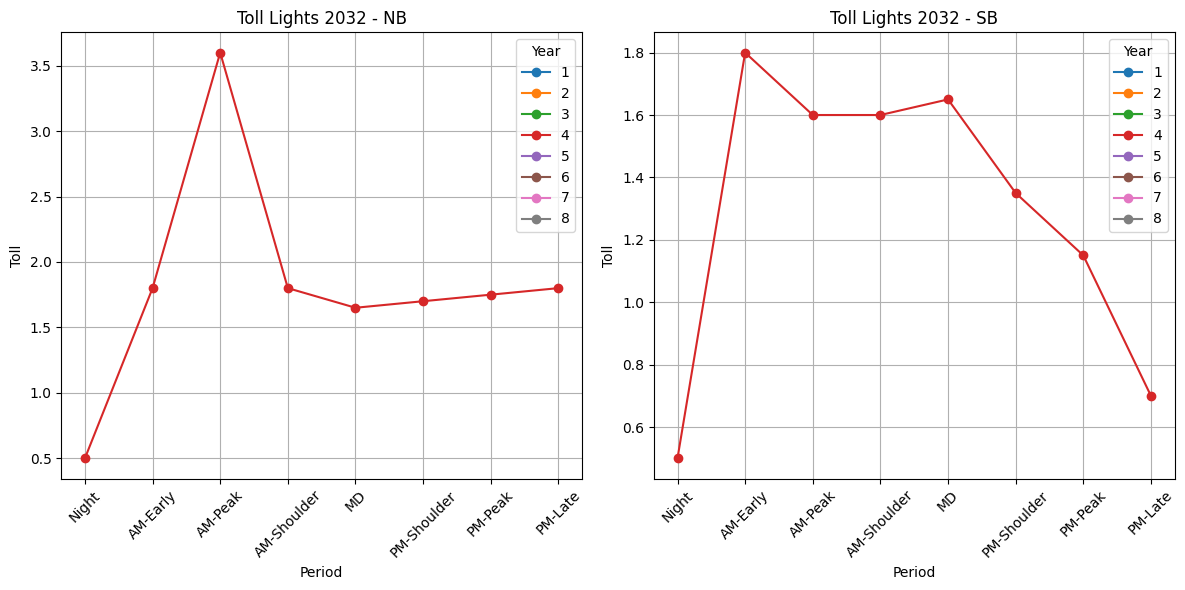

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Cargar CSV
# model_run = pd.read_csv("outputs\\2025-09-02\\19-01-04_1\\model_run.csv")
# model_run = pd.read_csv("outputs\\2025-09-10\\18-28-56_1\\model_run.csv")
# model_run = pd.read_csv("outputs\\2025-09-12\\18-59-17_1\\model_run.csv")
model_run = pd.read_csv(f"{run_folder}\\model_run.csv")

# model_run = pd.read_csv("outputs\\2025-09-15\\cap_categories_v1\\model_run.csv")

year_val = 2032

model_run = model_run.loc[model_run["Year"] == year_val]

model_run.loc[model_run['Period'] == 'Night', 'TollLights'] = 0.5

# 2. Definir años y direcciones
segments = [1,2,3,4,5,6,7,8]
directions = ["NB", "SB"]

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    for segment in segments:
        df = model_run[(model_run["Segment"] == segment) & (model_run["Direction"] == direction)]
        plt.plot(df["Period"], df["TollLights"], marker='o', linestyle='-', label=str(segment))
        
    
    plt.title(f"Toll Lights {year_val} - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Toll")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

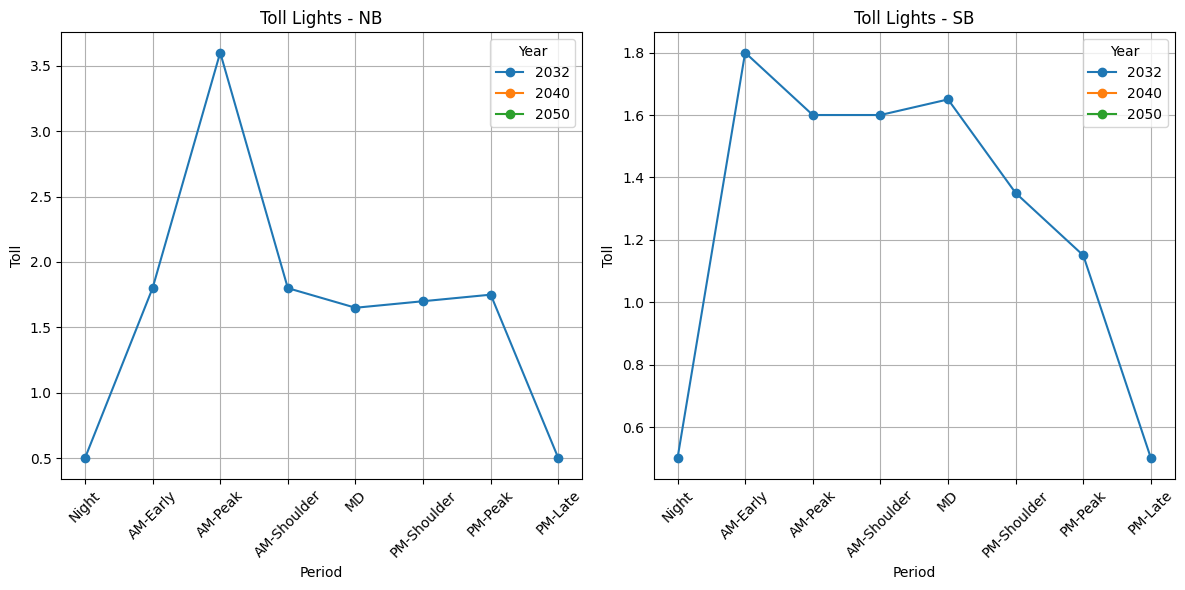

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# model_run = pd.read_csv("outputs\\2025-09-12\\18-59-17_1\\model_run.csv")
# model_run = pd.read_csv("outputs\\2025-09-11\\total_v1\\model_run.csv")
# model_run = pd.read_csv("outputs\\2025-09-10\\18-28-56_1\\model_run.csv")
model_run = pd.read_csv(f"{run_folder}\\model_run.csv")
# model_run = pd.read_csv("outputs\\2025-09-15\\cap_categories_v1\\model_run.csv")

years = [2032, 2040, 2050]
directions = ["NB", "SB"]

model_run = model_run.loc[model_run["Segment"] == 4] #2

model_run.loc[model_run['Period'] == 'Night', 'TollLights'] = 0.5
model_run.loc[model_run['Period'] == 'PM-Late', 'TollLights'] = 0.5

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
        
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        #if year == 2050:
        #    df["TollLights"] = df["TollLights"].clip(upper=5.15)
        #if year == 2040:
        #    df["TollLights"] = df["TollLights"].clip(upper=4.2)
        #if year == 2032:
        #    df["TollLights"] = df["TollLights"].clip(upper=3.6)

        plt.plot(df["Period"], df["TollLights"], marker='o', linestyle='-', label=str(year))   
    
    
    df_cap_50 = pd.DataFrame({"Value": [5.15] * 8})
    df_cap_40 = pd.DataFrame({"Value": [4.2] * 8})
    df_cap_32 = pd.DataFrame({"Value": [3.6] * 8})
    # plt.plot(df["Period"], df_cap_50["Value"], marker='o', linestyle='--', color='green') 
    # plt.plot(df["Period"], df_cap_40["Value"], marker='o', linestyle='--', color='orange') 
    # plt.plot(df["Period"], df_cap_32["Value"], marker='o', linestyle='--', color='blue')
    # df_cap_s50 = pd.DataFrame({"Value": [5.15/2] * 8})
    # df_cap_s40 = pd.DataFrame({"Value": [4.2/2] * 8})
    # df_cap_s32 = pd.DataFrame({"Value": [3.6/2] * 8})
    # plt.plot(df["Period"], df_cap_s50["Value"], marker='o', linestyle='--', color='green') 
    # plt.plot(df["Period"], df_cap_s40["Value"], marker='o', linestyle='--', color='orange') 
    # plt.plot(df["Period"], df_cap_s32["Value"], marker='o', linestyle='--', color='blue') 

    plt.title(f"Toll Lights - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Toll")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

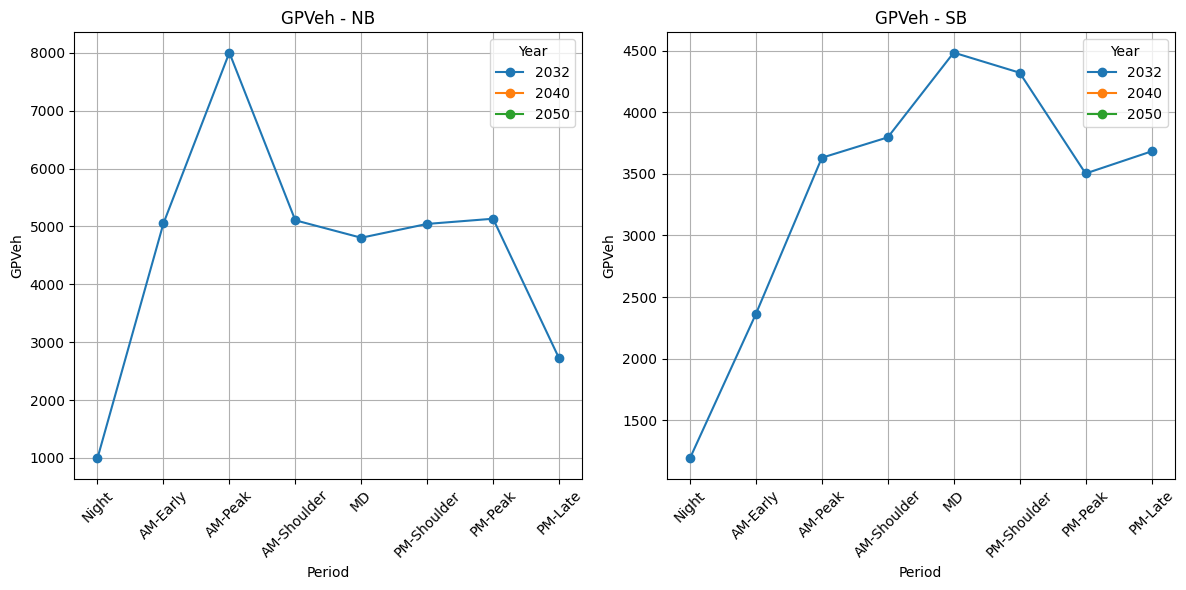

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        plt.plot(df["Period"], df["GPVeh"], marker='o', linestyle='-', label=str(year))
    
    plt.title(f"GPVeh - {direction}")
    plt.xlabel("Period")
    plt.ylabel("GPVeh")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

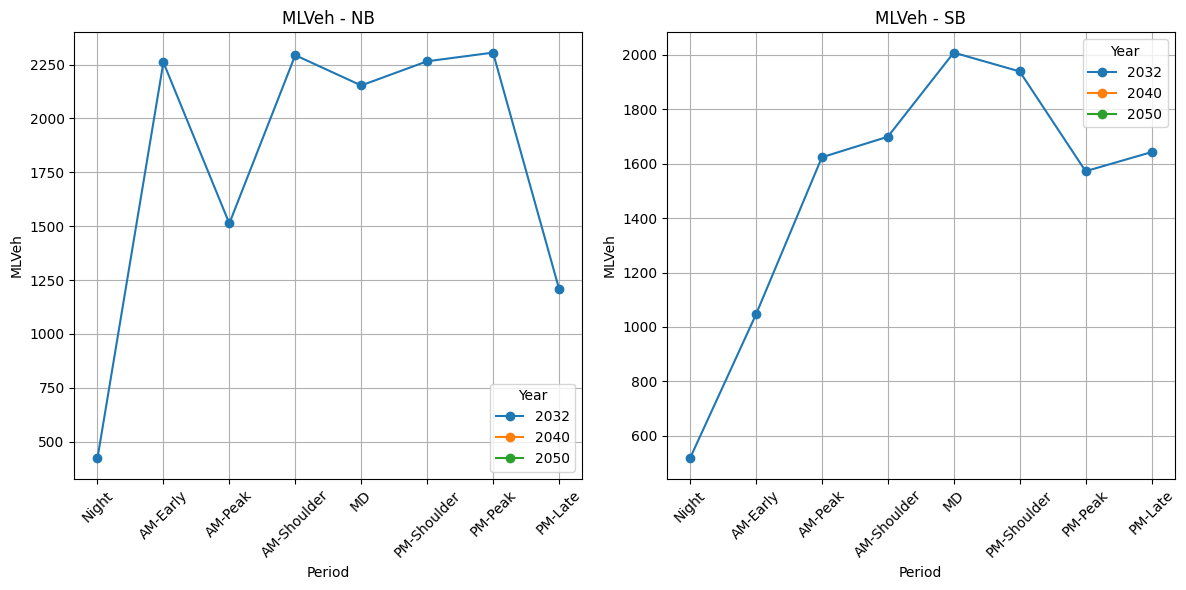

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        plt.plot(df["Period"], df["MLVeh"], marker='o', linestyle='-', label=str(year))
    
    plt.title(f"MLVeh - {direction}")
    plt.xlabel("Period")
    plt.ylabel("MLVeh")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

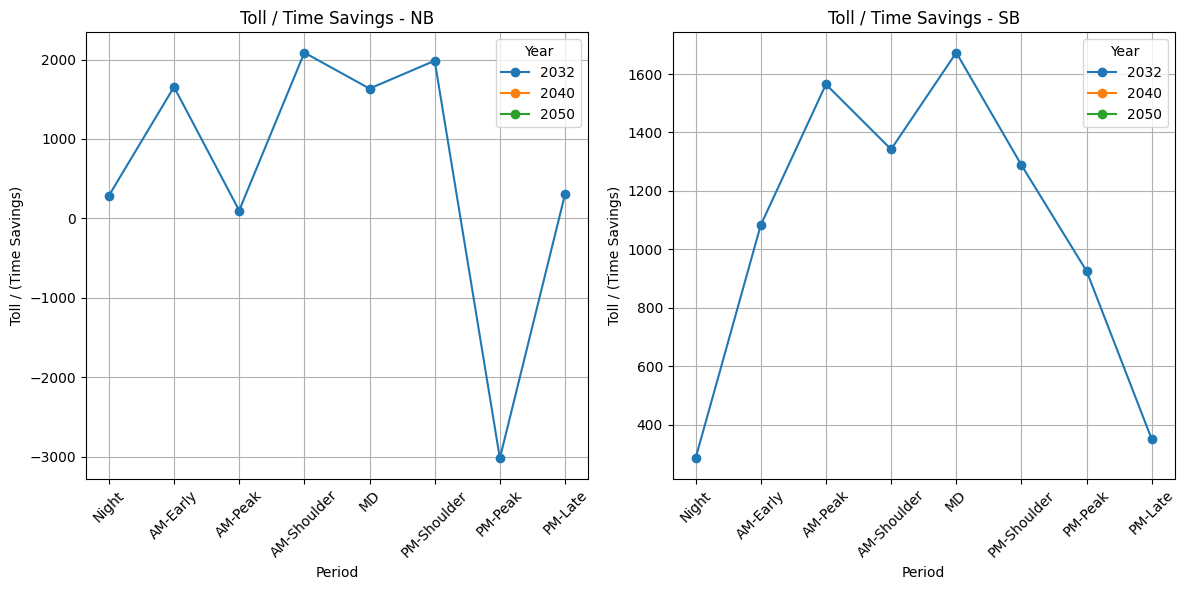

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        plt.plot(df["Period"], (60 * df["TollLights"] / (df["Time GP"] - df["Time ML"])), marker='o', linestyle='-', label=str(year))
    
    plt.title(f"Toll / Time Savings - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Toll / (Time Savings)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

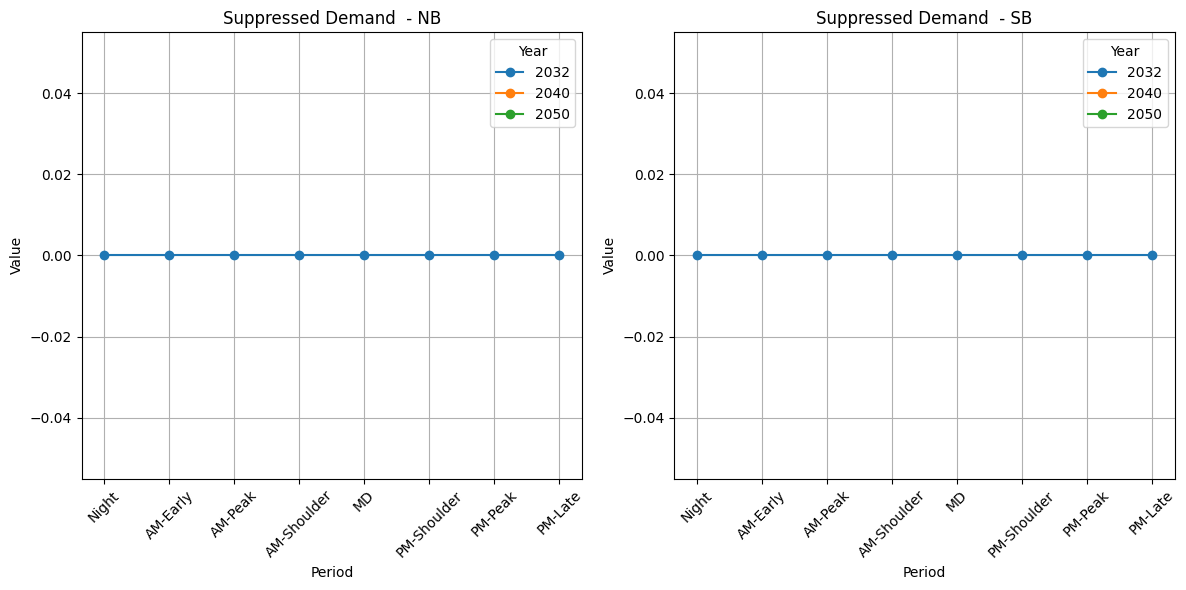

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        plt.plot(df["Period"], df["Suppressed Demand"], marker='o', linestyle='-', label=str(year))
    
    plt.title(f"Suppressed Demand  - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Value")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

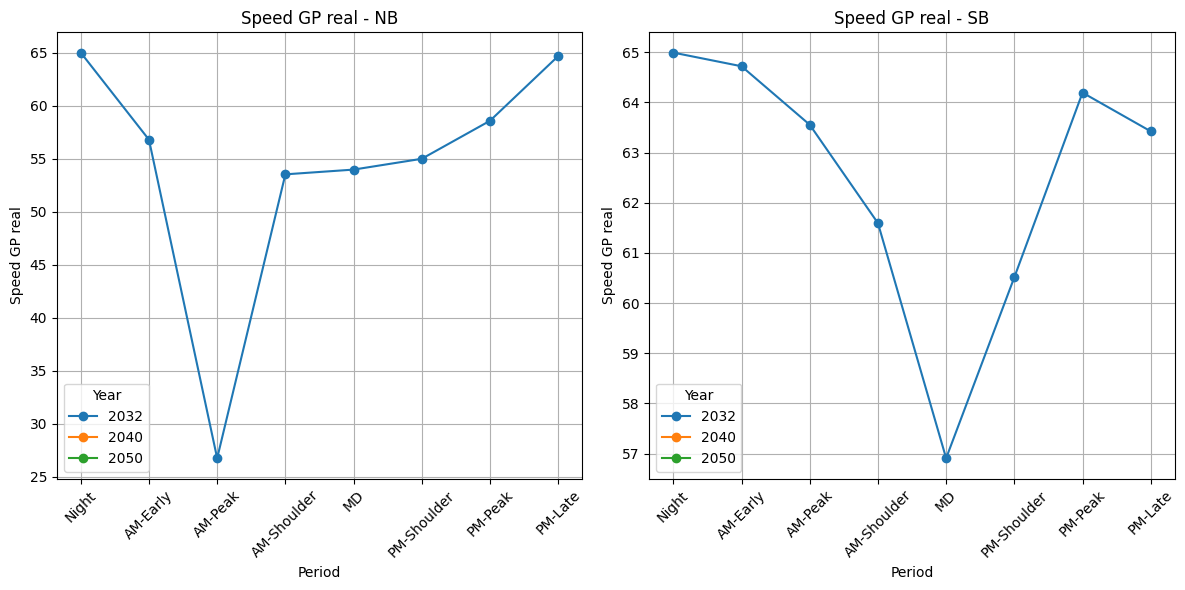

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        plt.plot(df["Period"], df["Speed GP Real"], marker='o', linestyle='-', label=str(year))
    
    plt.title(f"Speed GP real - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Speed GP real")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

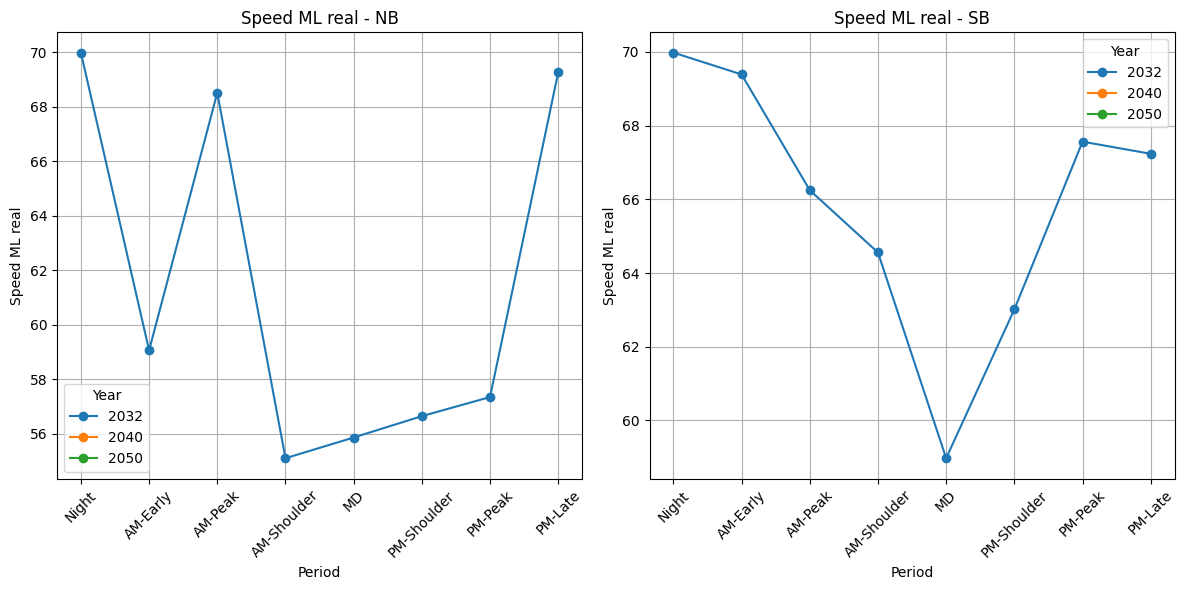

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        plt.plot(df["Period"], df["Speed ML Real"], marker='o', linestyle='-', label=str(year))
    
    plt.title(f"Speed ML real - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Speed ML real")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

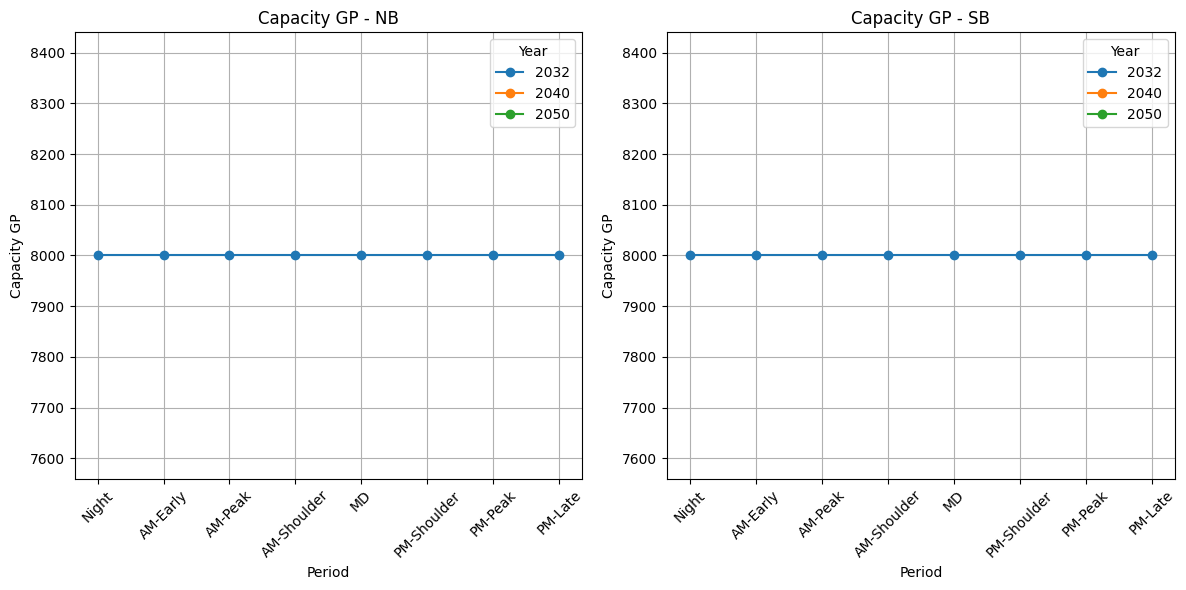

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        plt.plot(df["Period"], df["Capacity GP"], marker='o', linestyle='-', label=str(year))
    
    plt.title(f"Capacity GP - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Capacity GP")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()

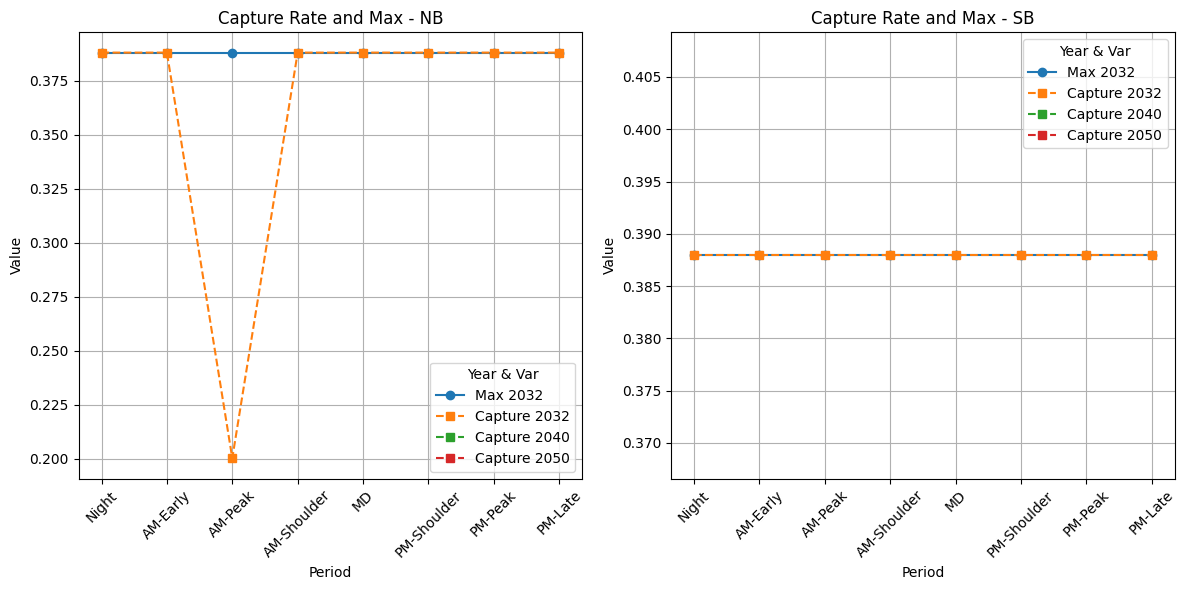

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction)]
        
        # Graficar Capture
        if year == years[0]:
            plt.plot(df["Period"], df["MaxCapture"], marker='o', linestyle='-', label=f"Max {year}")
        # Graficar Toll
        plt.plot(df["Period"], df["CaptureRateLights"], marker='s', linestyle='--', label=f"Capture {year}")
    
    plt.title(f"Capture Rate and Max - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Value")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year & Var")

plt.tight_layout()
plt.show()


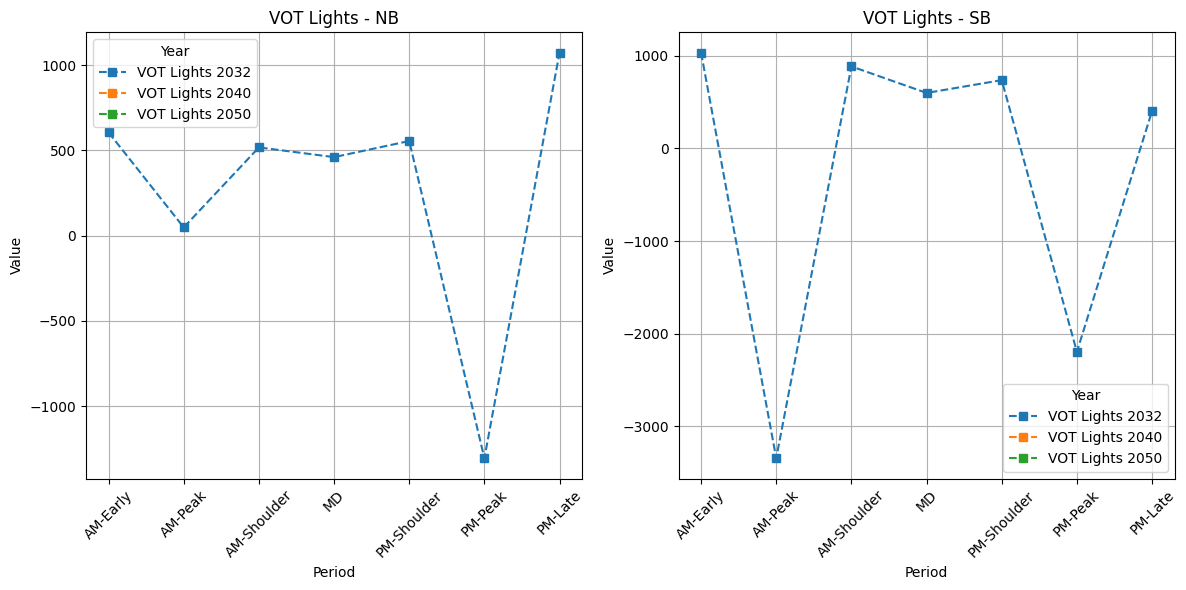

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for i, direction in enumerate(directions, 1):
    plt.subplot(1, 2, i)
    
    for year in years:
        df = model_run[(model_run["Year"] == year) & (model_run["Direction"] == direction) & (model_run["Period"] != "Night")]

        # Graficar Toll
        plt.plot(df["Period"], df["VOT Lights"], marker='s', linestyle='--', label=f"VOT Lights {year}")
    
    plt.title(f"VOT Lights - {direction}")
    plt.xlabel("Period")
    plt.ylabel("Value")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend(title="Year")

plt.tight_layout()
plt.show()
